# **ZPD**
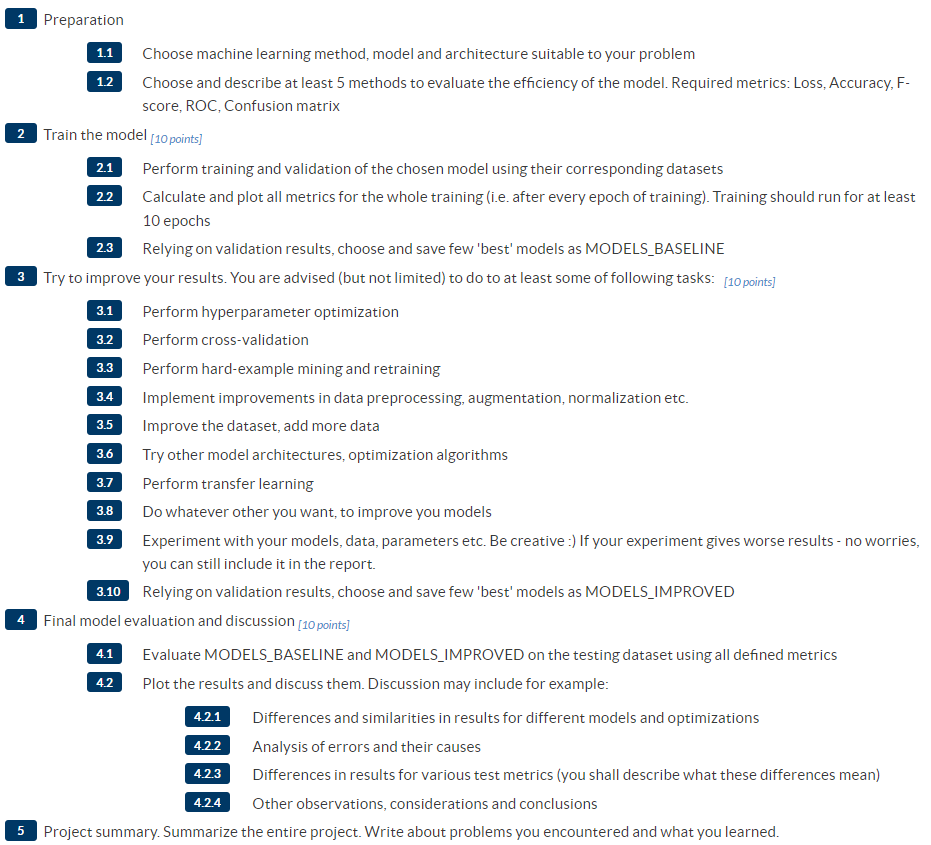

# 1. PREPARATION:
  1. Because our problem is image data classification, we will use transfer learning method and adapt MobileNet V2 developed by Google to our problem. Transfer learning enables us to use pre-trained model (with some data used by creators), and to fine-tune the model to out problem by training it again with data collected by us. It is a supervised learning problem. [https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c]
- [https://www.tensorflow.org/tutorials/images/transfer_learning]

  2. Because our problem is multi-class classification (labels from 0 to 4), possible loss functions are **Multi-Class Cross-Entropy Loss** (which is the default loss function to use for multi-class classification problems), **Sparse Multiclass Cross-Entropy Loss** (used to problems with a large number of labels, which require one hot encoding process; it is performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training) and **Kullback Leibler Divergence Loss** (most commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. Nevertheless, it can be used for multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy). 
[https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/]
- Chosen metrics to evaluate the model: 
      - **Loss: Multi-Class Cross-Entropy Loss**. Cross-entropy is the default loss function to use for multi-class classification problems. In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value. 
      - **Accuracy**. 
      - **F-score**.
      - **ROC**
      - **Confusion matrix**. 


# SZUM
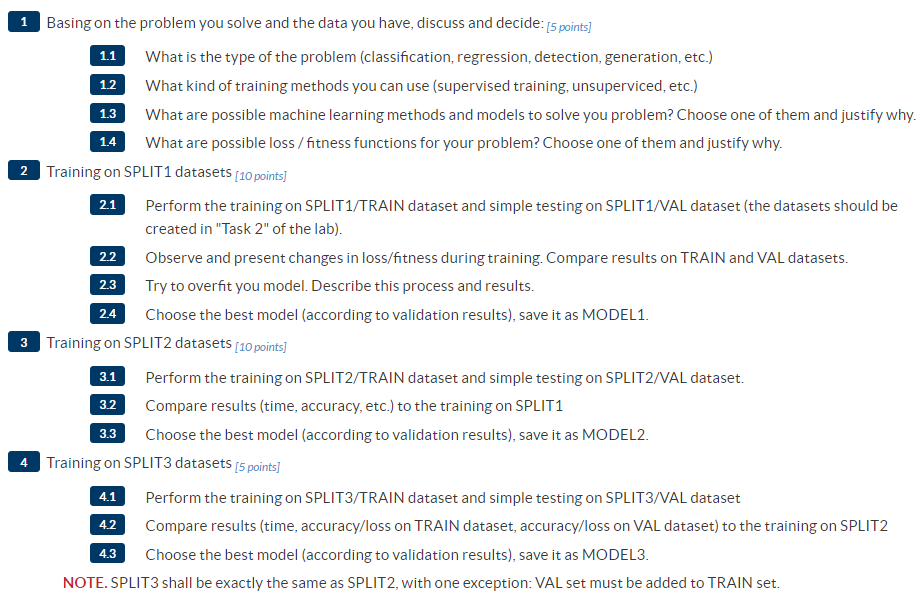

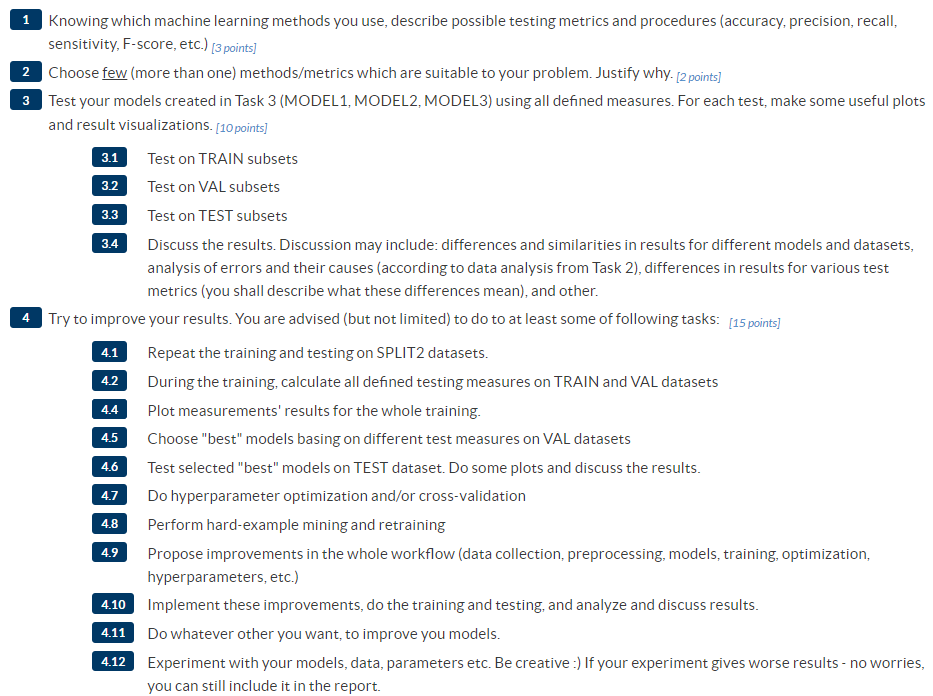

# MODEL TESTING

# Imports, constants and paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import json

In [3]:
root_directory = "/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/"
plots = root_directory + 'plots/'
testset1_path = root_directory + "testset1/"
testset2_path = root_directory + "testset2/"
valset1_path = root_directory + "valset1/"
valset2_path = root_directory + "valset2/"
valset3_path = root_directory + "valset3/"
trainset1_path = root_directory + "trainset1/"
trainset2_path = root_directory + "trainset2/"
trainset3_path = root_directory + "trainset3/"
models_path = root_directory + "models/"
log_file_path = models_path + "logs/"

# FUNCTIONS

In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [5]:
def prepare_testsets(testset_path1, testset_path2, log_file_path, model_name, plots_path=plots, batch_size=32, img_size_x=224, img_size_y=224):
  testset_dir1 = testset_path1
  testset_dir2 = testset_path2
  LOG_FILE = log_file_path + model_name + '_test_subsets.txt'

  BATCH_SIZE = batch_size
  IMG_SIZE = (img_size_x, img_size_y)
  # shape of my photos: 256x256
  # shape to choose from: 160x160, 224x224

  #test_dataset1
  test_dataset1 = tf.keras.utils.image_dataset_from_directory(testset_dir1,
                                                              labels='inferred',
                                                              shuffle=False,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)
  #test_dataset2
  test_dataset2 = tf.keras.utils.image_dataset_from_directory(testset_dir2,
                                                              labels='inferred',
                                                              shuffle=False,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)
  # exemplary calculation
  #                TRAIN  VAL     SUM
  # my calc:       6215   1553    7768
  # keras calc:    6474   1294    7768
  
  class_names1 = test_dataset1.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in test_dataset1.take(1):
    for i in range(9):
      if i == 0:
        IMAGES_SHAPE = "images shape: " + str(images[i].numpy().astype("uint8").shape)
        print(IMAGES_SHAPE)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names1[labels[i]])
      plt.axis("off")
  plt.savefig(plots_path + model_name + "test_dataset1_sample_examples.png")

  class_names2 = test_dataset2.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in test_dataset2.take(1):
    for i in range(9):
      if i == 0:
        IMAGES_SHAPE = "images shape: " + str(images[i].numpy().astype("uint8").shape)
        print(IMAGES_SHAPE)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names2[labels[i]])
      plt.axis("off")
  plt.savefig(plots_path + model_name + "test_dataset2_sample_examples.png")

  nr_test1_batches = tf.data.experimental.cardinality(test_dataset1)
  nr_test2_batches = tf.data.experimental.cardinality(test_dataset2)
  print('Number of test_dataset1 batches: %d' % nr_test1_batches)
  print('Number of test_dataset2 batches: %d' % nr_test2_batches)

  # performance options
  AUTOTUNE = tf.data.AUTOTUNE
  test_dataset1 = test_dataset1.prefetch(buffer_size=AUTOTUNE)
  test_dataset2 = test_dataset2.prefetch(buffer_size=AUTOTUNE)
  #test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("MODEL: " + str(model_name) + "\n") 
    # np.array(test_dataset.class_names)
    f.write("class_names: " + str(np.array(class_names1)) + "\n") 
    # len(classes)
    f.write("number of classes: " + str(len(class_names1)) + "\n") 
    # (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
    f.write("test_dataset1.element_spec: " + str(test_dataset1.element_spec) + "\n") 
    f.write("test_dataset2.element_spec: " + str(test_dataset2.element_spec) + "\n") 
    # type(test_dataset)
    f.write("type(test_dataset1): " + str(type(test_dataset1)) + "\n") 
    f.write("type(test_dataset2): " + str(type(test_dataset2)) + "\n") 
    # IMAGES_SHAPE
    f.write("IMAGES_SHAPE after scaling: " + str(IMAGES_SHAPE) + "\n") 
    # batches
    f.write("Number of test_dataset1 batches: " + str(test_dataset1) + "\n") 
    f.write("Number of test_dataset2 batches: " + str(test_dataset2) + "\n") 

  return test_dataset1, test_dataset2, class_names1, class_names2

In [6]:
def prepare_datasets(trainset_path, valset_path, log_file_path, model_name, plots_path=plots, batch_size=32, shuffle=True, img_size_x=224, img_size_y=224):
  train_dir = trainset_path
  validation_dir = valset_path
  LOG_FILE = log_file_path + model_name + '.txt'

  BATCH_SIZE = batch_size
  IMG_SIZE = (img_size_x, img_size_y)
  # shape of my photos: 256x256
  # shape to choose from: 160x160, 224x224

  #train dataset
  train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                              labels='inferred',
                                                              shuffle=shuffle,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)
  #val dataset
  validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=shuffle,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
  # exemplary calculation
  #                TRAIN  VAL     SUM
  # my calc:       6215   1553    7768
  # keras calc:    6474   1294    7768
  
  class_names = train_dataset.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in train_dataset.take(1):
    for i in range(9):
      if i == 0:
        IMAGES_SHAPE = "images shape: " + str(images[i].numpy().astype("uint8").shape)
        print(IMAGES_SHAPE)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  plt.savefig(plots_path + model_name + "_sample_examples.png")

  nr_train_batches = tf.data.experimental.cardinality(train_dataset)
  nr_val_batches = tf.data.experimental.cardinality(validation_dataset)
  print('Number of train batches: %d' % nr_train_batches)
  print('Number of validation batches: %d' % nr_val_batches)

  # performance options
  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
  #test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("MODEL: " + str(model_name) + "\n") 
    # np.array(train_dataset.class_names)
    f.write("class_names: " + str(np.array(class_names)) + "\n") 
    # len(classes)
    f.write("number of classes: " + str(len(class_names)) + "\n") 
    # (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
    f.write("train_dataset.element_spec: " + str(train_dataset.element_spec) + "\n") 
    # type(train_dataset)
    f.write("type(train_dataset): " + str(type(train_dataset)) + "\n") 
    # IMAGES_SHAPE
    f.write("IMAGES_SHAPE after scaling: " + str(IMAGES_SHAPE) + "\n") 
    # batches
    f.write("Number of train batches: " + str(nr_train_batches) + "\n") 
    f.write("Number of validation batches: " + str(nr_val_batches) + "\n") 

  return train_dataset, validation_dataset

In [7]:
def prepare_model(train_dataset, log_file_path, model_name, img_size_x=224, img_size_y=224):
  LOG_FILE = log_file_path + model_name + '.txt'
  BASE_MODEL_PATH = log_file_path + model_name + '_basemodelsummary.txt'
  IMG_SIZE = (img_size_x, img_size_y)

  IMG_SHAPE = IMG_SIZE + (3,)
  print("IMG_SHAPE: ", IMG_SHAPE)
  # Create the base model from the pre-trained model MobileNet V2
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                 include_top=False,
                                                 weights='imagenet')
  #example batch size
  image_batch, label_batch = next(iter(train_dataset))
  feature_batch = base_model(image_batch)
  print("example batch size", feature_batch.shape)

  # freeze the convolutional base
  base_model.trainable = False

  # Let's save the base model architecture
  with open(BASE_MODEL_PATH, 'a', encoding = 'utf-8') as f:
    base_model.summary(print_fn=lambda x: f.write(x + '\n'))

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
  # rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # ALTERNATIVE to preprocess_input
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  prediction_layer = tf.keras.layers.Dense(5) # try without , activation='relu'; number of neurons should be = num_classes
  prediction_batch = prediction_layer(feature_batch_average)

  # BUILD MODEL
  inputs = tf.keras.Input(shape=IMG_SHAPE) #(224, 224, 3)
  #x = data_augmentation(inputs) # NO AUGMENTATION!! (offline was used before)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Let's save the logs
  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("example batch size: " + str(feature_batch.shape) + "\n") 
    f.write("feature_batch_average.shape: " + str(feature_batch_average.shape) + "\n") # (32, 1280)
    f.write("prediction_batch.shape: " + str(prediction_batch.shape) + "\n") # (32, 5)
  
  return train_dataset, model

In [8]:
def compile_and_fit_model(train_dataset, validation_dataset, log_file_path, plots_path, model_name, base_learning_rate=0.0001, 
                          epochs=25, early_stopping_epochs=3):
  LOG_FILE = log_file_path + model_name + '.txt'
  COMPILED_MODEL_PATH = log_file_path + model_name + '_compiledmodelsummary.txt'

  # COMPILE MODEL
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #CategoricalCrossentropy(from_logits=True)
                metrics=['accuracy'])
  
  # Let's save the compiled model architecture
  with open(COMPILED_MODEL_PATH, 'a', encoding = 'utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

  # TRAIN THE MODEL
  initial_epochs = epochs
  loss0, accuracy0 = model.evaluate(validation_dataset)
  print("initial loss: {:.2f}".format(loss0))
  print("initial accuracy: {:.2f}".format(accuracy0))

  # set Early Stopping to 3 epochs
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping_epochs)
  # FIT THE MODEL
  history = model.fit(train_dataset,
                      epochs=initial_epochs,
                      validation_data=validation_dataset,
                      callbacks=[callback],
                      verbose=1)

  epochs_performed = len(history.history['loss'])
  print("epochs_performed: ", epochs_performed)

  loss1, accuracy1 = model.evaluate(validation_dataset)
  print("loss after training: {:.2f}".format(loss1))
  print("accuracy after training: {:.2f}".format(accuracy1))

  # Let's save the logs
  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("model.trainable_variables: " + str(model.trainable_variables) + " (two tf.Variable objects, the weights and biases)" + "\n") 
    f.write("initial loss: " + str(loss0) + "\n") 
    f.write("initial accuracy: " + str(accuracy0) + "\n") 
    f.write("learning_rate: " + str(base_learning_rate) + "\n") 
    f.write("max_epochs: " + str(epochs) + "\n") 
    f.write("epochs_performed: " + str(epochs_performed) + "\n") 
    f.write("EarlyStopping (nr_of_epochs): " + str(early_stopping_epochs) + "\n") 
    f.write("loss after training: " + str(loss1) + "\n") 
    f.write("accuracy after training: " + str(accuracy1) + "\n") 

  # PLOT TRAINING RESULTS
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(plots_path + model_name + '_acc_loss.png')
  plt.show()

  return model

In [9]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    #batched=False means that the set is in the form of batches, but we don't want them anymore 
    # (so we want to get rid of them)

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [10]:
def calculate_metrics(test_dataset_labels, test_dataset_binarized_labels, test_dataset_predicted_probs, test_dataset_predicted_labels):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_dataset_labels, test_dataset_predicted_labels)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_dataset_labels, test_dataset_predicted_labels, average='weighted')
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_dataset_labels, test_dataset_predicted_labels, average='weighted')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_dataset_labels, test_dataset_predicted_labels, average='weighted')
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(test_dataset_labels, test_dataset_predicted_labels)
    print('Cohens kappa: %f' % kappa)
    # # ROC AUC
    auc = roc_auc_score(test_dataset_binarized_labels, test_dataset_predicted_probs, average='weighted', multi_class='ovr')
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(test_dataset_labels, test_dataset_predicted_labels)
    print("Confusion matrix: ", matrix)
    # confusion matrix 2
    array = matrix
    df_cm = pd.DataFrame(array, range(5), range(5))
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    categories = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()
    # confusion matrix 3
    #labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’] #obly for binary classification
    categories = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
    make_confusion_matrix(matrix, 
                          #group_names=labels,
                          categories=categories, 
                          figsize=(8,6),
                          cmap='viridis',
                          sum_stats=True,
                          title='Confusion matrix',
                          cbar=True)
    # Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_curve, auc
    n_classes=5
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_dataset_binarized_labels[:, i], test_dataset_predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_dataset_binarized_labels.ravel(), test_dataset_predicted_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # ROC - AUC curve
    lw = 2
    #dpi=400
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(14,8))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()
    # ROC AUC in numbers
    macro_roc_auc_ovo = roc_auc_score(test_dataset_binarized_labels, test_dataset_predicted_probs, multi_class="ovo", average="macro")
    weighted_roc_auc_ovo = roc_auc_score(test_dataset_binarized_labels, test_dataset_predicted_probs, multi_class="ovo", average="weighted")
    macro_roc_auc_ovr = roc_auc_score(test_dataset_binarized_labels, test_dataset_predicted_probs, multi_class="ovr", average="macro")
    weighted_roc_auc_ovr = roc_auc_score(test_dataset_binarized_labels, test_dataset_predicted_probs, multi_class="ovr", average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

# TEST DATASETS PREPARATION

Found 131 files belonging to 5 classes.
Found 800 files belonging to 5 classes.
images shape: (224, 224, 3)
images shape: (224, 224, 3)
Number of test_dataset1 batches: 5
Number of test_dataset2 batches: 25


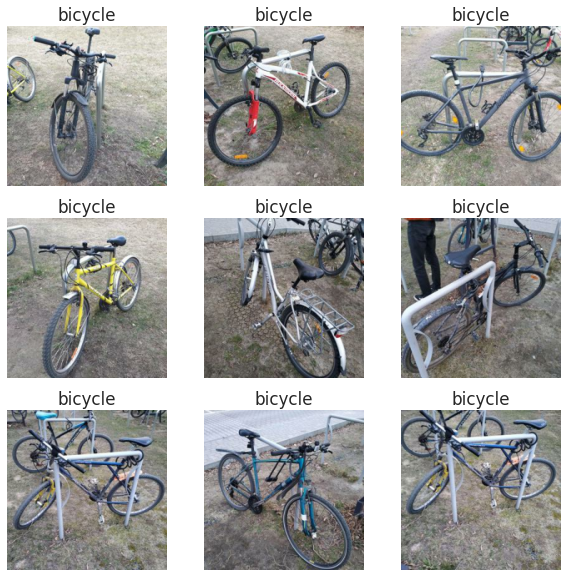

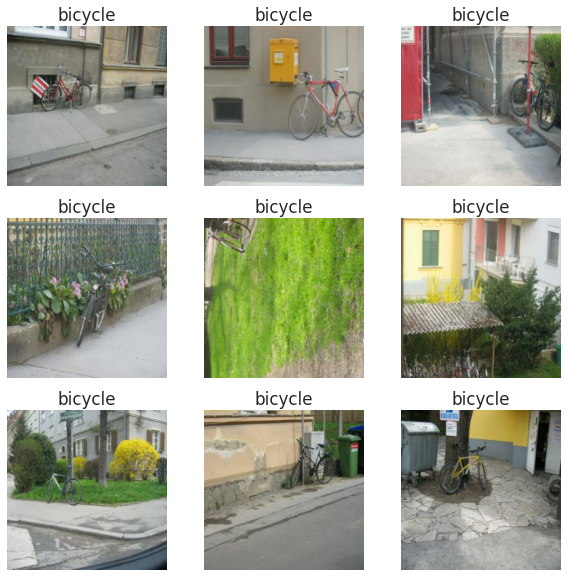

In [ ]:
test_dataset1, test_dataset2, class_names1, class_names2 = prepare_testsets(testset_path1=testset1_path, testset_path2=testset2_path, 
                                                                            log_file_path=log_file_path, model_name='none', 
                                                                            plots_path=plots, batch_size=32, #batch_size=None or batch_size=1
                                                                            img_size_x=224, img_size_y=224)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


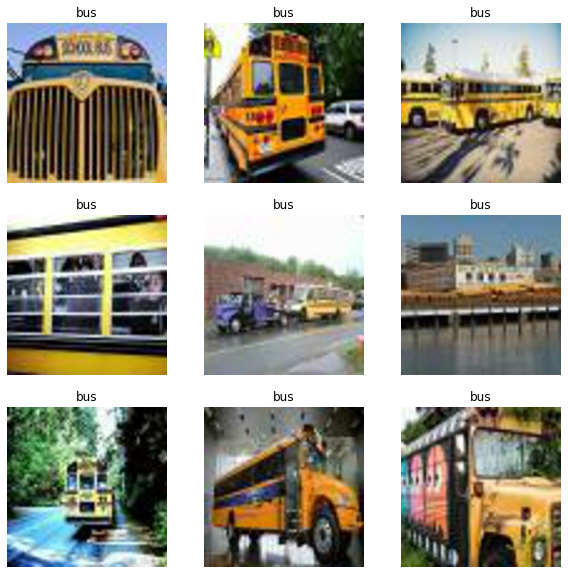

In [ ]:
class_names = class_names1
shift=3
plt.figure(figsize=(10, 10))
for images, labels in test_dataset2.take(9):
  for i in range(0+shift, 9+shift):
    ax = plt.subplot(3, 3, i-shift + 1)
    plt.imshow(images[i+shift].numpy().astype("uint8"))
    plt.title(class_names[labels[i+shift]])
    plt.axis("off")
#plt.savefig(plots_path + model_name + "_sample_examples.png")

# MODEL3 EVALUATION*

In [ ]:
MODEL_NAME = 'MODEL3_BASELINE'
trainset_path = trainset3_path
valset_path = valset3_path

model = keras.models.load_model(models_path + MODEL_NAME)
print(model)

# train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset_path, valset_path=valset_path, 
#                                                     log_file_path=log_file_path, model_name=MODEL_NAME, 
#                                                     plots_path=plots, batch_size=32, shuffle=False, # do not shuffle if testing
#                                                     img_size_x=224, img_size_y=224)

losstest1, accuracytest1 = model.evaluate(test_dataset1)
losstest2, accuracytest2 = model.evaluate(test_dataset2)
print(MODEL_NAME)
print("TEST ON TEST SETS")
print(f'Test accuracy (testset1): {accuracytest1}; Test loss (testset1): {losstest1}')
print(f'Test accuracy (testset2): {accuracytest2}; Test loss (testset2): {losstest2}')

25/25 [==============================] - 2s 76ms/step - loss: 0.0657 - accuracy: 0.9787
MODEL3_BASELINE
TEST ON TEST SETS
Test accuracy (testset1): 0.7709923386573792; Test loss (testset1): 0.8035969138145447
Test accuracy (testset2): 0.9787499904632568; Test loss (testset2): 0.06566710770130157


In [ ]:
test_dataset1_labels = get_labels_from_tfdataset(test_dataset1, batched=False)
test_dataset1_binarized_labels = label_binarize(test_dataset1_labels, classes=[0, 1, 2, 3, 4])
test_dataset1_predicted_probs = model.predict(test_dataset1)
test_dataset1_predicted_labels = np.argmax(test_dataset1_predicted_probs, axis=1)

In [ ]:
test_dataset2_labels = get_labels_from_tfdataset(test_dataset2, batched=False)
test_dataset2_binarized_labels = label_binarize(test_dataset2_labels, classes=[0, 1, 2, 3, 4])
test_dataset2_predicted_probs = model.predict(test_dataset2)
test_dataset2_predicted_labels = np.argmax(test_dataset2_predicted_probs, axis=1)

### Test set 1 evaluation

Accuracy: 0.770992
Precision: 0.832831
Recall: 0.770992
F1 score: 0.724929
Cohens kappa: 0.709234
ROC AUC: 0.967337
Confusion matrix:  [[25  0  0  0  0]
 [ 0  2  8  0 13]
 [ 0  0 31  0  0]
 [ 0  0  0 31  0]
 [ 0  0  9  0 12]]


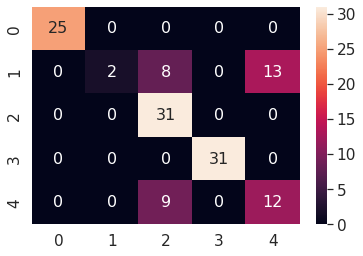

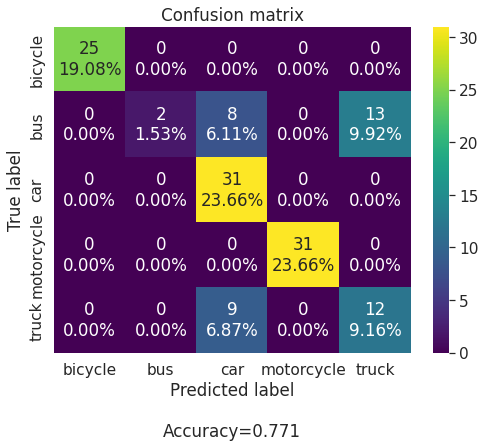

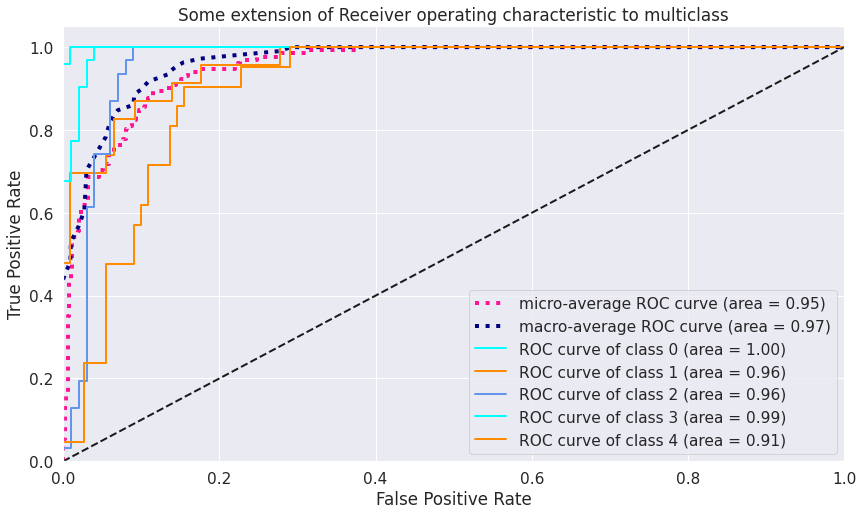

One-vs-One ROC AUC scores:
0.964262 (macro),
0.967337 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.964262 (macro),
0.967337 (weighted by prevalence)


In [ ]:
test_dataset_labels = test_dataset1_labels
test_dataset_binarized_labels = test_dataset1_binarized_labels
test_dataset_predicted_probs = test_dataset1_predicted_probs
test_dataset_predicted_labels = test_dataset1_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

### Test set 2 evaluation

Accuracy: 0.978750
Precision: 0.979164
Recall: 0.978750
F1 score: 0.978626
Cohens kappa: 0.973437
ROC AUC: 0.996771
Confusion matrix:  [[159   0   0   1   0]
 [  0 160   0   0   0]
 [  0   0 158   0   2]
 [  0   0   0 159   1]
 [  0   3  10   0 147]]


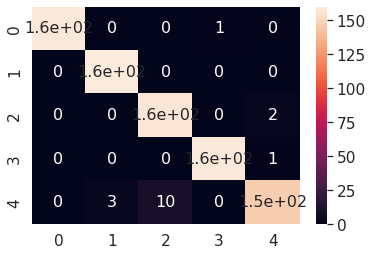

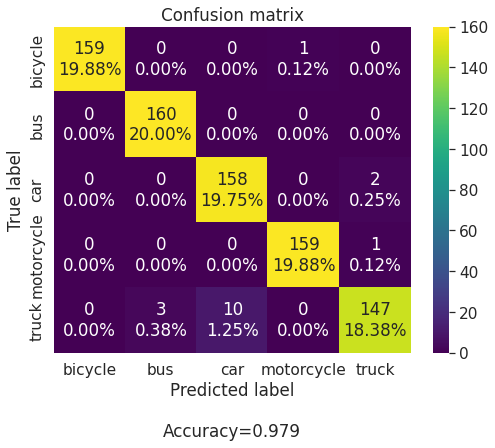

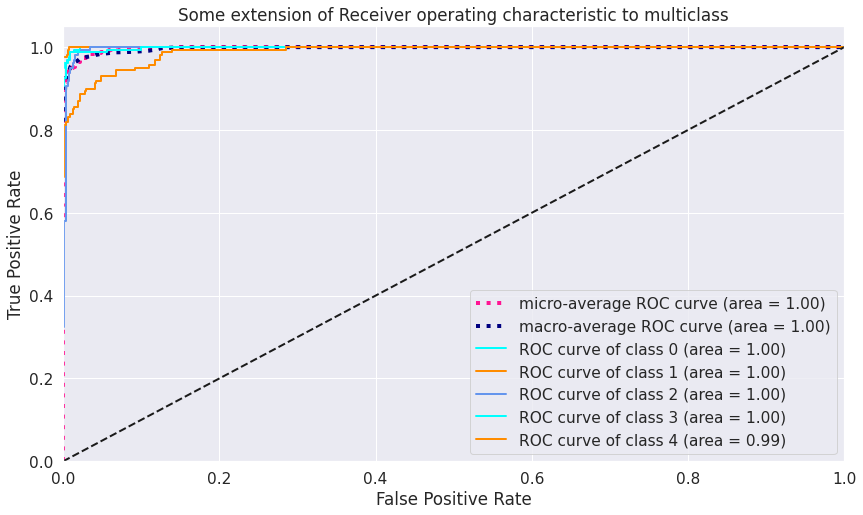

One-vs-One ROC AUC scores:
0.996771 (macro),
0.996771 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996771 (macro),
0.996771 (weighted by prevalence)


In [ ]:
test_dataset_labels = test_dataset2_labels
test_dataset_binarized_labels = test_dataset2_binarized_labels
test_dataset_predicted_probs = test_dataset2_predicted_probs
test_dataset_predicted_labels = test_dataset2_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

# MODEL2 EVALUATION

Found 13151 files belonging to 5 classes.
Found 3286 files belonging to 5 classes.
images shape: (224, 224, 3)
Number of train batches: 411
Number of validation batches: 103
25/25 [==============================] - 2s 84ms/step - loss: 0.0683 - accuracy: 0.9775
MODEL2_BASELINE
TEST ON TEST SETS
Test accuracy (testset1): 0.7633587718009949; Test loss (testset1): 0.9123318791389465
Test accuracy (testset2): 0.9775000214576721; Test loss (testset2): 0.06827779114246368


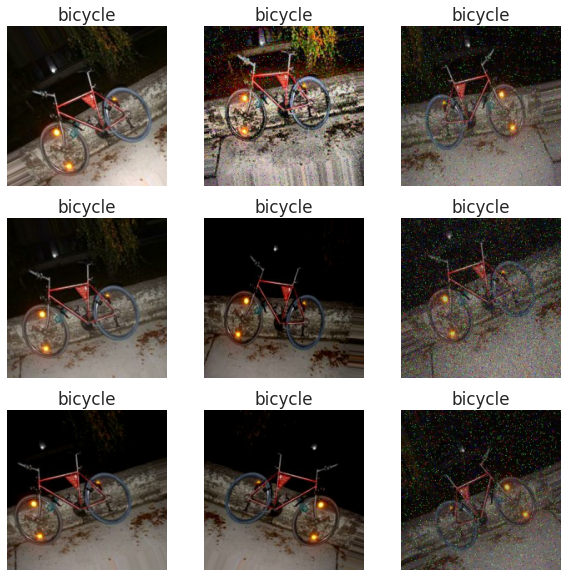

In [ ]:
MODEL_NAME = 'MODEL2_BASELINE'
trainset_path = trainset2_path
valset_path = valset2_path

model = keras.models.load_model(models_path + MODEL_NAME)
print(model)

train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset_path, valset_path=valset_path, 
                                                    log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                    plots_path=plots, batch_size=32, shuffle=False, # do not shuffle if testing
                                                    img_size_x=224, img_size_y=224)

losstest1, accuracytest1 = model.evaluate(test_dataset1)
losstest2, accuracytest2 = model.evaluate(test_dataset2)
print(MODEL_NAME)
print("TEST ON TEST SETS")
print(f'Test accuracy (testset1): {accuracytest1}; Test loss (testset1): {losstest1}')
print(f'Test accuracy (testset2): {accuracytest2}; Test loss (testset2): {losstest2}')

In [ ]:
test_dataset1_labels = get_labels_from_tfdataset(test_dataset1, batched=False)
test_dataset1_binarized_labels = label_binarize(test_dataset1_labels, classes=[0, 1, 2, 3, 4])
test_dataset1_predicted_probs = model.predict(test_dataset1)
test_dataset1_predicted_labels = np.argmax(test_dataset1_predicted_probs, axis=1)

In [ ]:
test_dataset2_labels = get_labels_from_tfdataset(test_dataset2, batched=False)
test_dataset2_binarized_labels = label_binarize(test_dataset2_labels, classes=[0, 1, 2, 3, 4])
test_dataset2_predicted_probs = model.predict(test_dataset2)
test_dataset2_predicted_labels = np.argmax(test_dataset2_predicted_probs, axis=1)

### Test set 1 evaluation

Accuracy: 0.763359
Precision: 0.658818
Recall: 0.763359
F1 score: 0.701382
Cohens kappa: 0.700074
ROC AUC: 0.957340
Confusion matrix:  [[25  0  0  0  0]
 [ 0  0  7  0 16]
 [ 0  0 31  0  0]
 [ 0  0  0 31  0]
 [ 0  0  8  0 13]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


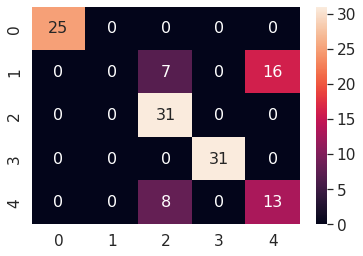

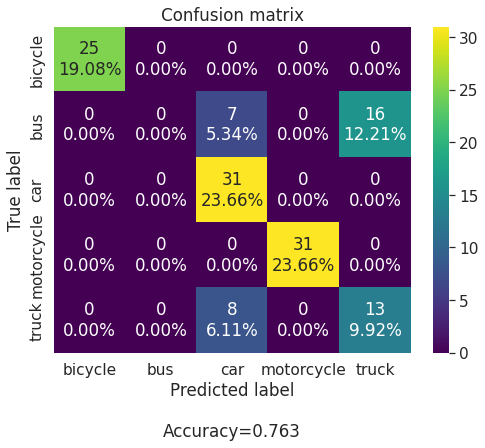

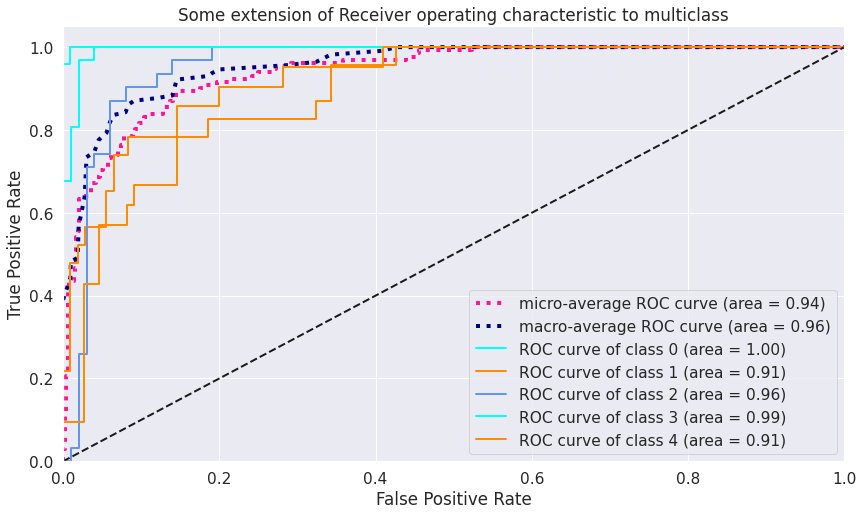

One-vs-One ROC AUC scores:
0.953278 (macro),
0.957340 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.953278 (macro),
0.957340 (weighted by prevalence)


In [ ]:
test_dataset_labels = test_dataset1_labels
test_dataset_binarized_labels = test_dataset1_binarized_labels
test_dataset_predicted_probs = test_dataset1_predicted_probs
test_dataset_predicted_labels = test_dataset1_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

### Test set 2 evaluation

Accuracy: 0.977500
Precision: 0.977768
Recall: 0.977500
F1 score: 0.977309
Cohens kappa: 0.971875
ROC AUC: 0.996211
Confusion matrix:  [[160   0   0   0   0]
 [  0 160   0   0   0]
 [  0   0 158   0   2]
 [  0   0   0 158   2]
 [  1   4   9   0 146]]


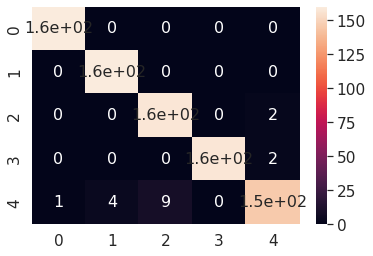

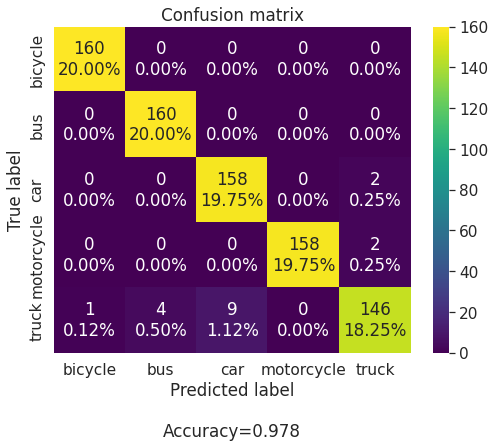

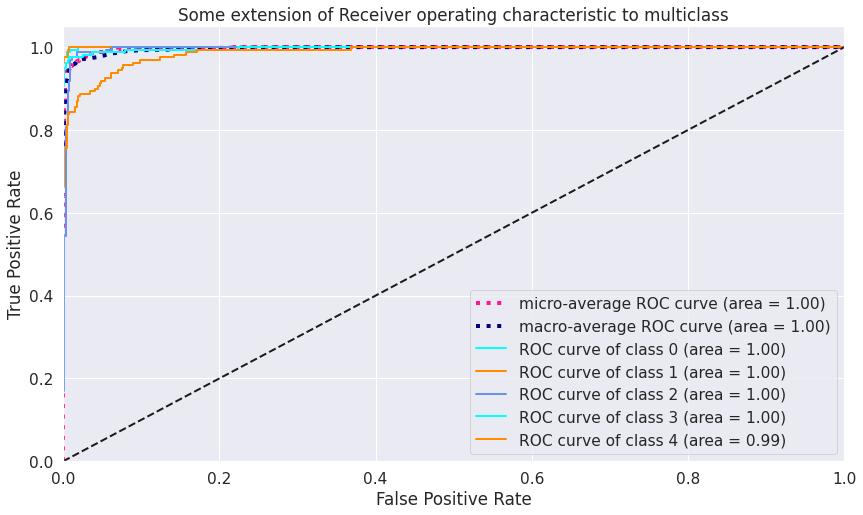

One-vs-One ROC AUC scores:
0.996211 (macro),
0.996211 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996211 (macro),
0.996211 (weighted by prevalence)


In [ ]:
test_dataset_labels = test_dataset2_labels
test_dataset_binarized_labels = test_dataset2_binarized_labels
test_dataset_predicted_probs = test_dataset2_predicted_probs
test_dataset_predicted_labels = test_dataset2_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

# MODEL1 EVALUTION
```
Number of test_dataset1 batches: 5
Number of test_dataset2 batches: 25
5/5 [==============================] - 12s 92ms/step - loss: 0.8324 - accuracy: 0.7710
25/25 [==============================] - 63s 3s/step - loss: 0.0991 - accuracy: 0.9650
TEST ON TEST SETS
Test accuracy (testset1): 0.7709923386573792; Test loss (testset1): 0.8324359655380249
Test accuracy (testset2): 0.9649999737739563; Test loss (testset2): 0.09914302825927734
203/203 [==============================] - 887s 4s/step - loss: 0.0520 - accuracy: 0.9859
TEST ON TRAIN SET
Test accuracy (trainset): 0.9859437942504883; Test loss (trainset): 0.05196651071310043
41/41 [==============================] - 187s 4s/step - loss: 0.0869 - accuracy: 0.9722
TEST ON VAL SET
Test accuracy (valset): 0.9721792936325073; Test loss (valset): 0.08692227303981781
```



In [ ]:
MODEL_NAME = 'MODEL1_BASELINE'
model = keras.models.load_model(models_path + MODEL_NAME)
print(model)

Found 6474 files belonging to 5 classes.
Found 1294 files belonging to 5 classes.
images shape: (224, 224, 3)
Number of train batches: 203
Number of validation batches: 41
Found 131 files belonging to 5 classes.
Found 800 files belonging to 5 classes.
images shape: (224, 224, 3)
images shape: (224, 224, 3)
Number of test_dataset1 batches: 5
Number of test_dataset2 batches: 25
25/25 [==============================] - 100s 4s/step - loss: 0.0991 - accuracy: 0.9650
TEST ON TEST SETS
Test accuracy (testset1): 0.7709923386573792; Test loss (testset1): 0.8324359655380249
Test accuracy (testset2): 0.9649999737739563; Test loss (testset2): 0.09914302825927734


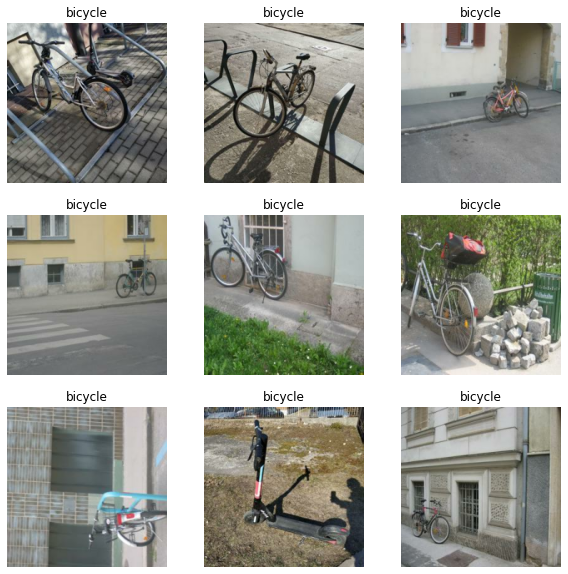

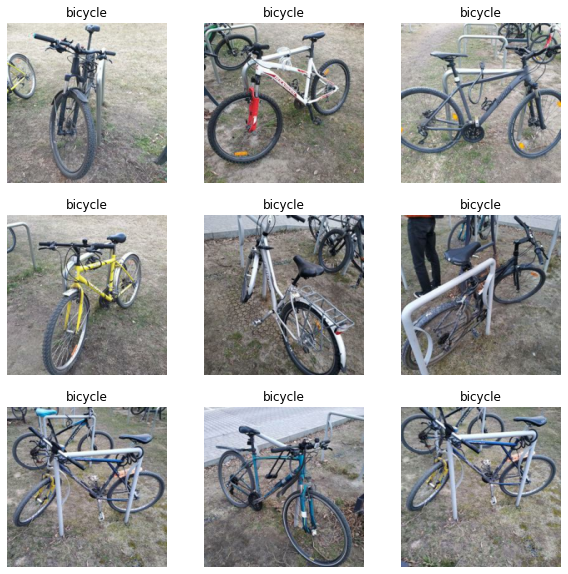

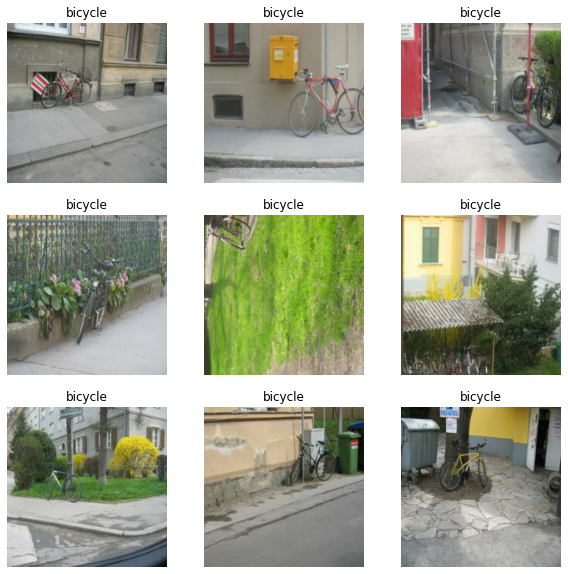

In [ ]:
trainset_path = trainset1_path
valset_path = valset1_path
train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset_path, valset_path=valset_path, 
                                                    log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                    plots_path=plots, batch_size=32, shuffle=False, # do not shuffle if testing
                                                    img_size_x=224, img_size_y=224)

test_dataset1, test_dataset2, class_names1, class_names2 = prepare_testsets(testset_path1=testset1_path, testset_path2=testset2_path, 
                                                                            log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                                            plots_path=plots, batch_size=32, #batch_size=None or batch_size=1
                                                                            img_size_x=224, img_size_y=224)
losstest1, accuracytest1 = model.evaluate(test_dataset1)
losstest2, accuracytest2 = model.evaluate(test_dataset2)
print("TEST ON TEST SETS")
print(f'Test accuracy (testset1): {accuracytest1}; Test loss (testset1): {losstest1}')
print(f'Test accuracy (testset2): {accuracytest2}; Test loss (testset2): {losstest2}')
# losstrain, accuracytrain = model.evaluate(train_dataset)
# print("TEST ON TRAIN SET")
# print(f'Test accuracy (trainset): {accuracytrain}; Test loss (trainset): {losstrain}')
# lossval, accuracyval = model.evaluate(validation_dataset)
# print("TEST ON VAL SET")
# print(f'Test accuracy (valset): {accuracyval}; Test loss (valset): {lossval}')

## Get: 
- test_dataset1_labels
```
<tf.Tensor: shape=(131,), dtype=int32, numpy=
array([3, 3, 1, 0, 1, 3, 4, 3, 3, 3, 0, 0, 3, 1, 1, 2, 0, 3, 1, 2, 1, 3,
       4, 4, 1, 0, 0, 0, 4, 0, 4, 1, 4, 2, 0, 3, 2, 3, 0, 4, 0, 2, 2, 1,
       2, 2, 1, 4, 4, 3, 4, 4, 2, 4, 3, 1, 4, 4, 2, 2, 3, 3, 2, 3, 2, 3,
       1, 1, 4, 0, 4, 2, 1, 1, 0, 3, 2, 4, 3, 3, 1, 0, 1, 3, 2, 0, 2, 2,
       1, 2, 3, 1, 0, 3, 0, 2, 3, 2, 0, 4, 1, 0, 4, 3, 2, 0, 1, 3, 3, 0,
       1, 2, 2, 2, 0, 0, 4, 3, 3, 2, 2, 4, 0, 0, 3, 2, 3, 2, 1, 2, 2],
      dtype=int32)>
```
- test_dataset1_binarized_labels
```
array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
```
- test_dataset1_predicted_probs
```
array([[-4.9044704 , -6.1150575 ,  2.428482  , -3.9387693 , -5.1350064 ],
       [-6.599805  , -4.788226  ,  3.7193193 , -5.181446  , -2.5456045 ],
       [-5.315931  , -0.89231944, -0.29638642, -7.0807376 ,  0.09412026],
```
- test_dataset1_predicted_labels
```
array([4, 2, 3, 3, 3, 3, 0, 4, 0, 2, 0, 3, 3, 0, 2, 0, 2, 4, 4, 3, 2, 2,
       0, 0, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 3, 0, 4, 2, 2, 3, 2, 2, 3, 3,
       3, 4, 4, 2, 4, 2, 4, 2, 0, 2, 3, 3, 4, 4, 4, 2, 2, 2, 0, 0, 2, 4,
       4, 4, 2, 2, 0, 4, 0, 3, 0, 2, 2, 2, 2, 0, 4, 3, 2, 0, 2, 4, 2, 4,
       3, 4, 2, 4, 3, 0, 0, 2, 3, 2, 3, 0, 0, 2, 3, 2, 2, 0, 0, 2, 2, 2,
       3, 2, 3, 2, 2, 4, 2, 4, 4, 2, 0, 1, 2, 3, 3, 2, 0, 3, 4, 3, 0])
```

https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset

In [ ]:
print(test_dataset1)
for example in test_dataset1:
  #print(example[0].numpy()) # IMAGES
  print(example[1].numpy()) # LABELS

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4 4 4]


In [ ]:
for example in train_dataset:
  #print(example[0].numpy()) # IMAGES
  print(example[1].numpy()) # LABELS

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1

In [ ]:
test_dataset1_labels = get_labels_from_tfdataset(test_dataset1, batched=False)
test_dataset1_labels

<tf.Tensor: shape=(131,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int32)>

In [ ]:
test_dataset1_binarized_labels = label_binarize(test_dataset1_labels, classes=[0, 1, 2, 3, 4])
test_dataset1_binarized_labels

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0,

In [ ]:
test_dataset1_predicted_probs = model.predict(test_dataset1)
#display(test_dataset1_predicted_probs)
"""
array([[-4.9044704 , -6.1150575 ,  2.428482  , -3.9387693 , -5.1350064 ],
       [-6.599805  , -4.788226  ,  3.7193193 , -5.181446  , -2.5456045 ],
       [-5.315931  , -0.89231944, -0.29638642, -7.0807376 ,  0.09412026],"""

#test_dataset1_predicted_probs_really = tf.nn.softmax(test_dataset1_predicted_probs)
#display(test_dataset1_predicted_probs_really)
""""""
test_dataset1_predicted_labels = np.argmax(test_dataset1_predicted_probs, axis=1)
display(test_dataset1_predicted_labels)
"""
array([0, 3, 2, 2, 4, 2, 3, 3, 2, 0, 0, 3, 3, 0, 1, 3, 2, 3, 3, 4, 2, 2,
       4, 3, 4, 2, 3, 2, 2, 0, 3, 4, 2, 3, 0, 2, 2, 4, 2, 4, 0, 3, 0, 2,"""

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4,
       1, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2])

'\narray([0, 3, 2, 2, 4, 2, 3, 3, 2, 0, 0, 3, 3, 0, 1, 3, 2, 3, 3, 4, 2, 2,\n       4, 3, 4, 2, 3, 2, 2, 0, 3, 4, 2, 3, 0, 2, 2, 4, 2, 4, 0, 3, 0, 2,'

In [ ]:
display(test_dataset1_predicted_probs)

array([[ 3.3810773 , -5.4127207 , -3.6946068 ,  1.7537885 , -5.3273964 ],
       [ 5.0070186 , -5.17487   , -3.2289896 , -0.10815454, -3.8657198 ],
       [ 5.0694475 , -5.0153027 , -3.6647482 , -1.490962  , -4.3484716 ],
       [ 3.3227968 , -4.34748   , -3.1767912 ,  1.3998142 , -5.7245064 ],
       [ 6.035137  , -5.0809507 , -3.850081  ,  0.3358262 , -6.2734246 ],
       [ 3.5464375 , -6.4722114 , -4.8000503 , -0.1835701 , -5.3611765 ],
       [ 5.4124613 , -4.024412  , -2.469121  , -1.2755262 , -4.5455475 ],
       [ 5.3162746 , -3.8215678 , -2.55028   , -1.391141  , -4.66854   ],
       [ 5.9005013 , -4.4253206 , -3.0238295 , -1.3518044 , -4.6868696 ],
       [ 3.1337602 , -4.9183016 , -3.540956  ,  2.8302474 , -6.221245  ],
       [ 6.324378  , -5.7644105 , -4.389067  ,  0.06812227, -5.569676  ],
       [ 4.254759  , -4.9978604 , -2.3757915 , -3.8448176 , -5.0382586 ],
       [ 4.44098   , -5.727446  , -2.4284787 , -3.6458142 , -6.240299  ],
       [ 1.768094  , -5.9870033 , -3.1

In [ ]:
test_dataset2_labels = get_labels_from_tfdataset(test_dataset2, batched=False)
test_dataset2_binarized_labels = label_binarize(test_dataset2_labels, classes=[0, 1, 2, 3, 4])
test_dataset2_predicted_probs = model.predict(test_dataset2)
test_dataset2_predicted_labels = np.argmax(test_dataset2_predicted_probs, axis=1)

In [ ]:
train_dataset_labels = get_labels_from_tfdataset(train_dataset, batched=False)
train_dataset_binarized_labels = label_binarize(train_dataset_labels, classes=[0, 1, 2, 3, 4])
train_dataset_predicted_probs = model.predict(train_dataset)
train_dataset_predicted_labels = np.argmax(train_dataset_predicted_probs, axis=1)

In [ ]:
validation_dataset_labels = get_labels_from_tfdataset(validation_dataset, batched=False)
validation_dataset_binarized_labels = label_binarize(validation_dataset_labels, classes=[0, 1, 2, 3, 4])
validation_dataset_predicted_probs = model.predict(validation_dataset)
validation_dataset_predicted_labels = np.argmax(validation_dataset_predicted_probs, axis=1)

## Calculate metrics for testset1: accuracy, recall, precion, f1-score, cohen_kappa, ROC_AUC, confusion matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_dataset1_labels, test_dataset1_predicted_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_dataset1_labels, test_dataset1_predicted_labels, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_dataset1_labels, test_dataset1_predicted_labels, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_dataset1_labels, test_dataset1_predicted_labels, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.770992
Precision: 0.836037
Recall: 0.770992
F1 score: 0.716510


In [ ]:
# kappa
kappa = cohen_kappa_score(test_dataset1_labels, test_dataset1_predicted_labels)
print('Cohens kappa: %f' % kappa)
# # ROC AUC
auc = roc_auc_score(test_dataset1_binarized_labels, test_dataset1_predicted_probs, average='weighted', multi_class='ovr')
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_dataset1_labels, test_dataset1_predicted_labels)
print(matrix)

Cohens kappa: 0.709277
ROC AUC: 0.966050
[[25  0  0  0  0]
 [ 0  1  9  0 13]
 [ 0  0 31  0  0]
 [ 0  0  0 31  0]
 [ 0  0  8  0 13]]


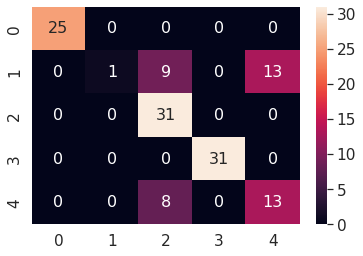

In [ ]:
array = matrix

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
categories = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

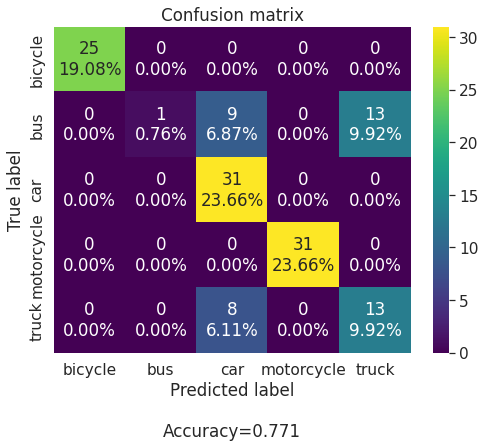

In [ ]:
#labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
categories = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
make_confusion_matrix(matrix, 
                      #group_names=labels,
                      categories=categories, 
                      figsize=(8,6),
                      cmap='viridis',
                      sum_stats=True,
                      title='Confusion matrix',
                      cbar=True)

### ROC CURVE VISUALISATION

In [ ]:
from sklearn.metrics import roc_curve, auc
n_classes=5
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_dataset1_binarized_labels[:, i], test_dataset1_predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_dataset1_binarized_labels.ravel(), test_dataset1_predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

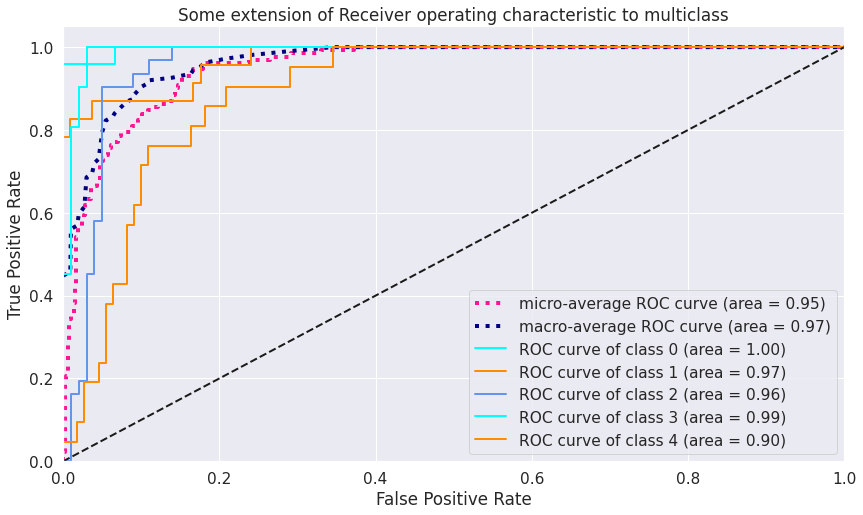

In [ ]:
lw = 2
#dpi=400
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(14,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [ ]:
macro_roc_auc_ovo = roc_auc_score(test_dataset1_binarized_labels, test_dataset1_predicted_probs, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_dataset1_binarized_labels, test_dataset1_predicted_probs, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(test_dataset1_binarized_labels, test_dataset1_predicted_probs, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_dataset1_binarized_labels, test_dataset1_predicted_probs, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)


## Calculate metrics for testset2, trainset and valset

Accuracy: 0.965000
Precision: 0.965819
Recall: 0.965000
F1 score: 0.964818
Cohens kappa: 0.956250
ROC AUC: 0.995930
Confusion matrix:  [[154   0   0   5   1]
 [  0 160   0   0   0]
 [  0   0 156   0   4]
 [  0   0   1 159   0]
 [  0   3  13   1 143]]


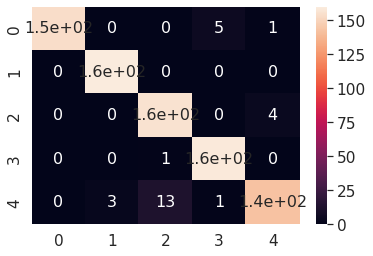

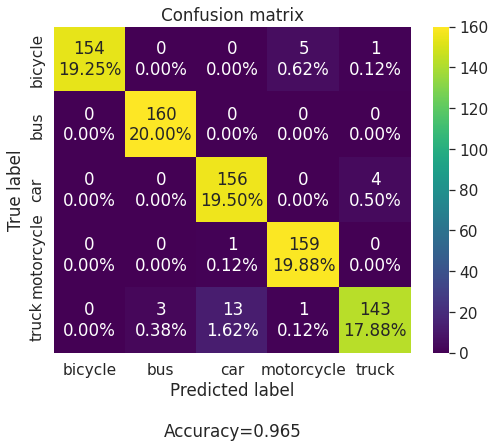

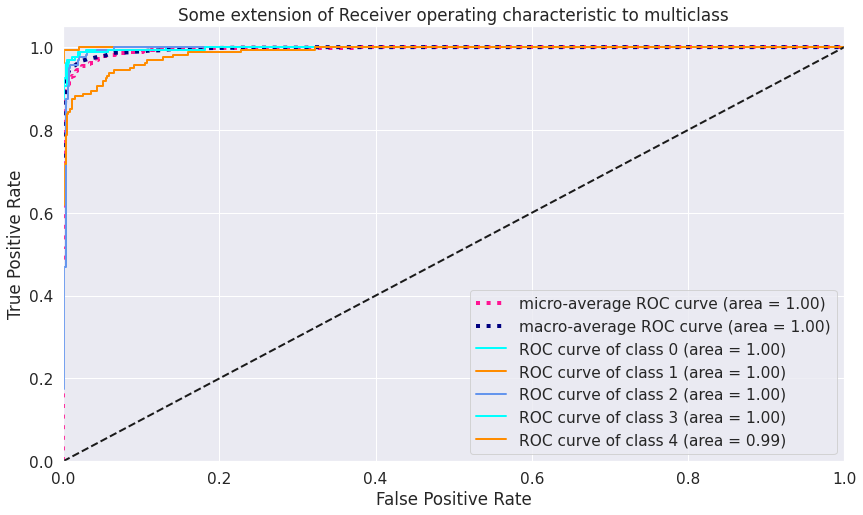

One-vs-One ROC AUC scores:
0.995930 (macro),
0.995930 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.995930 (macro),
0.995930 (weighted by prevalence)


In [ ]:
test_dataset_labels = test_dataset2_labels
test_dataset_binarized_labels = test_dataset2_binarized_labels
test_dataset_predicted_probs = test_dataset2_predicted_probs
test_dataset_predicted_labels = test_dataset2_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

Accuracy: 0.985944
Precision: 0.985945
Recall: 0.985944
F1 score: 0.985893
Cohens kappa: 0.979720
ROC AUC: 0.997542
Confusion matrix:  [[ 203    0    0    2    0]
 [   0  755   10    0    4]
 [   0    1 2764    1   19]
 [   1    0    4 1948    2]
 [   0    1   45    1  713]]


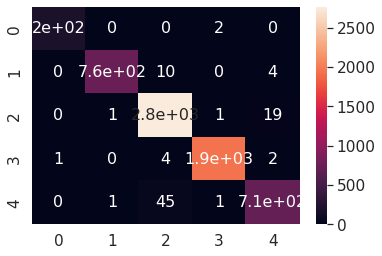

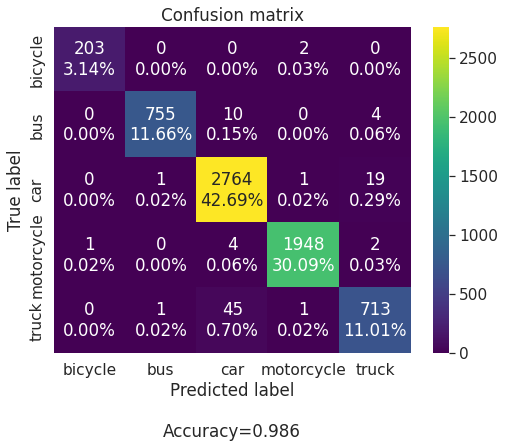

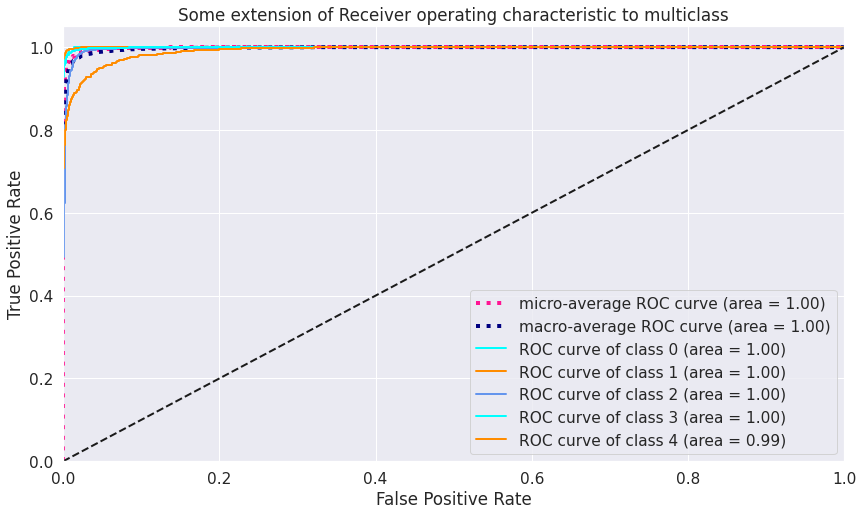

One-vs-One ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)


In [ ]:
test_dataset_labels = train_dataset_labels
test_dataset_binarized_labels = train_dataset_binarized_labels
test_dataset_predicted_probs = train_dataset_predicted_probs
test_dataset_predicted_labels = train_dataset_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

Accuracy: 0.972179
Precision: 0.971881
Recall: 0.972179
F1 score: 0.971833
Cohens kappa: 0.959790
ROC AUC: 0.994443
Confusion matrix:  [[ 41   0   0   0   0]
 [  0 151   2   0   0]
 [  1   0 545   0  11]
 [  0   0   0 391   0]
 [  0   0  21   1 130]]


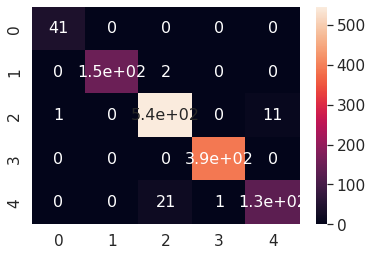

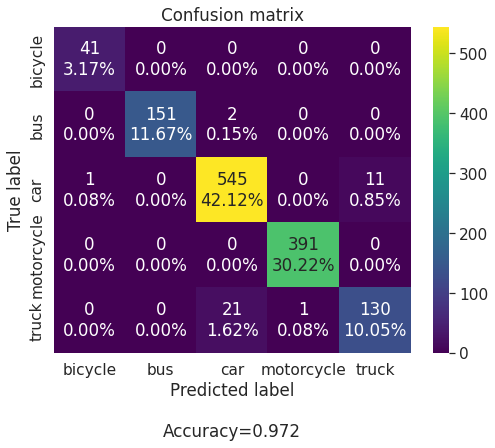

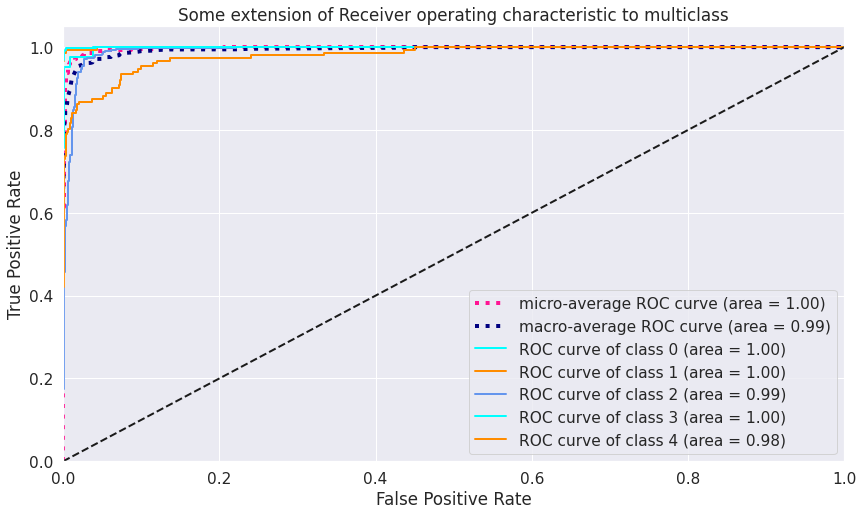

One-vs-One ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.963088 (macro),
0.966050 (weighted by prevalence)


In [ ]:
test_dataset_labels = validation_dataset_labels
test_dataset_binarized_labels = validation_dataset_binarized_labels
test_dataset_predicted_probs = validation_dataset_predicted_probs
test_dataset_predicted_labels = validation_dataset_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

## Iris example to create confusion matrix and ROC curve

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
display(y)
y = label_binarize(y, classes=[0, 1, 2])
display(y)
display(y.shape)
n_classes = y.shape[1]
display(n_classes)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

(150, 3)

3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    if i == 0:
      display(fpr[i])
      display(tpr[i])
      display(roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

array([0.        , 0.        , 0.        , 0.01851852, 0.01851852,
       0.03703704, 0.03703704, 0.05555556, 0.05555556, 0.07407407,
       0.07407407, 0.09259259, 0.09259259, 0.12962963, 0.12962963,
       0.14814815, 0.14814815, 0.2037037 , 0.2037037 , 0.27777778,
       0.27777778, 1.        ])

array([0.        , 0.04761905, 0.14285714, 0.14285714, 0.19047619,
       0.19047619, 0.33333333, 0.33333333, 0.38095238, 0.38095238,
       0.61904762, 0.61904762, 0.66666667, 0.66666667, 0.76190476,
       0.76190476, 0.9047619 , 0.9047619 , 0.95238095, 0.95238095,
       1.        , 1.        ])

0.9126984126984127

In [ ]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0,

In [ ]:
y_score

array([[-0.76301132, -0.36482547,  0.12386354],
       [-0.20224493, -0.63144366, -0.16612302],
       [ 0.11801481, -0.80263073, -0.32055874],
       [-0.90780855, -0.12395478,  0.02199789],
       [-0.01116192, -0.27913475, -0.71889214],
       [-0.6048727 , -0.34730509, -0.05859016],
       [ 0.02283491, -0.24506467, -0.79111998],
       [-0.61076876,  0.18264917, -0.57199363],
       [-0.37572754, -0.24059516, -0.38933694],
       [-0.47017411, -0.25745136, -0.27510839],
       [-0.42224234, -0.30270719, -0.27995197],
       [-0.3355867 , -0.7030665 ,  0.02530178],
       [-0.22723929, -0.64062258, -0.13456902],
       [-0.07856729, -0.46354017, -0.45918364],
       [-0.53383361, -0.2653183 , -0.20023832],
       [ 0.12163662, -0.56706353, -0.56980985],
       [-0.71356947, -0.04226738, -0.24297128],
       [-0.55111511, -0.13784913, -0.31370595],
       [ 0.37991331, -0.99673302, -0.39090964],
       [-0.11107635, -0.91349462,  0.03129167],
       [-0.70713712, -0.06436533, -0.214

In [ ]:
tpr

{0: array([0.  , 0.  , 0.  , 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0.2 , 0.2 ,
        0.24, 0.24, 0.28, 0.28, 0.32, 0.32, 0.36, 0.36, 0.4 , 0.4 , 0.48,
        0.48, 0.52, 0.52, 0.56, 0.56, 0.64, 0.64, 0.72, 0.72, 0.76, 0.76,
        0.8 , 0.8 , 0.84, 0.84, 0.88, 0.88, 0.92, 0.92, 1.  , 1.  ])}

In [ ]:
y_score

array([[-0.76301132, -0.36482547,  0.12386354],
       [-0.20224493, -0.63144366, -0.16612302],
       [ 0.11801481, -0.80263073, -0.32055874],
       [-0.90780855, -0.12395478,  0.02199789],
       [-0.01116192, -0.27913475, -0.71889214],
       [-0.6048727 , -0.34730509, -0.05859016],
       [ 0.02283491, -0.24506467, -0.79111998],
       [-0.61076876,  0.18264917, -0.57199363],
       [-0.37572754, -0.24059516, -0.38933694],
       [-0.47017411, -0.25745136, -0.27510839],
       [-0.42224234, -0.30270719, -0.27995197],
       [-0.3355867 , -0.7030665 ,  0.02530178],
       [-0.22723929, -0.64062258, -0.13456902],
       [-0.07856729, -0.46354017, -0.45918364],
       [-0.53383361, -0.2653183 , -0.20023832],
       [ 0.12163662, -0.56706353, -0.56980985],
       [-0.71356947, -0.04226738, -0.24297128],
       [-0.55111511, -0.13784913, -0.31370595],
       [ 0.37991331, -0.99673302, -0.39090964],
       [-0.11107635, -0.91349462,  0.03129167],
       [-0.70713712, -0.06436533, -0.214

In [ ]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)


In [ ]:
y_prob

array([[0.01932696, 0.26415219, 0.86416097],
       [0.35032281, 0.2736702 , 0.46092379],
       [0.78004015, 0.27989286, 0.22707434],
       [0.00822069, 0.255738  , 0.75851463],
       [0.6249326 , 0.26113857, 0.01865192],
       [0.04879405, 0.26353421, 0.64636913],
       [0.66883539, 0.25994657, 0.01132945],
       [0.04715476, 0.24528519, 0.05100057],
       [0.16055344, 0.25979046, 0.1543824 ],
       [0.09861932, 0.26037953, 0.28689108],
       [0.12683936, 0.26196536, 0.28008621],
       [0.19517481, 0.27626318, 0.76267728],
       [0.31518686, 0.27400166, 0.51538625],
       [0.52579188, 0.26765136, 0.10121862],
       [0.06984099, 0.26065475, 0.40359977],
       [0.78369587, 0.27135242, 0.05175907],
       [0.02585523, 0.25292475, 0.33752326],
       [0.06348661, 0.25621855, 0.23550099],
       [0.94353516, 0.28705214, 0.1529676 ],
       [0.47776416, 0.28396859, 0.77009791],
       [0.02685117, 0.25368376, 0.3811177 ],
       [0.60609374, 0.26749209, 0.06919831],
       [0.

# MODEL2 FINE TUNING AND LEARNING

Found 13151 files belonging to 5 classes.
Found 3286 files belonging to 5 classes.
images shape: (224, 224, 3)
Number of train batches: 411
Number of validation batches: 103


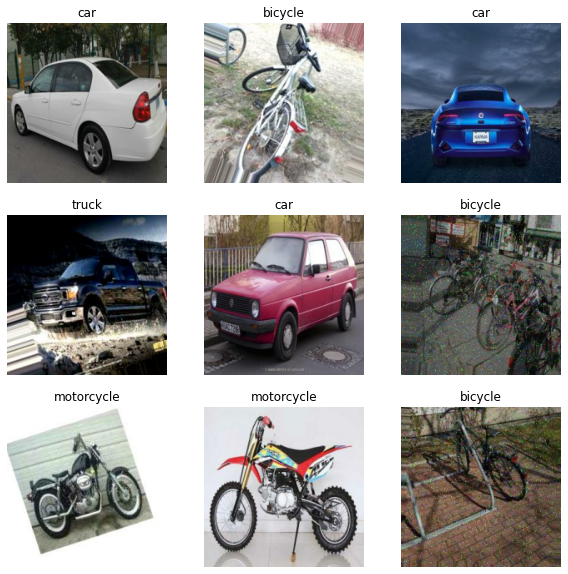

In [34]:
MODEL_NAME = 'MODEL2_BASELINE2'
trainset_path = trainset2_path
valset_path = valset2_path
train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset_path, valset_path=valset_path, 
                                                    log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                    plots_path=plots, batch_size=32, shuffle=True,
                                                    img_size_x=224, img_size_y=224)

In [35]:
model_name=MODEL_NAME
img_size_x=224
img_size_y=224
base_learning_rate=0.0001
epochs=25
early_stopping_epochs=3

LOG_FILE = log_file_path + model_name + '.txt'
BASE_MODEL_PATH = log_file_path + model_name + '_basemodelsummary.txt'
IMG_SIZE = (img_size_x, img_size_y)

IMG_SHAPE = IMG_SIZE + (3,)
print("IMG_SHAPE: ", IMG_SHAPE)
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
#example batch size
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("example batch size", feature_batch.shape)

# freeze the convolutional base
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # ALTERNATIVE to preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(5) # try without , activation='relu'; number of neurons should be = num_classes
prediction_batch = prediction_layer(feature_batch_average)

# BUILD MODEL
inputs = tf.keras.Input(shape=IMG_SHAPE) #(224, 224, 3)
#x = data_augmentation(inputs) # NO AUGMENTATION!! (offline was used before)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

IMG_SHAPE:  (224, 224, 3)
example batch size (32, 7, 7, 1280)


Epoch 1/25
411/411 [==============================] - 2865s 7s/step - loss: 0.5972 - accuracy: 0.8110 - val_loss: 0.2715 - val_accuracy: 0.9352
Epoch 2/25
411/411 [==============================] - 38s 92ms/step - loss: 0.2298 - accuracy: 0.9397 - val_loss: 0.1827 - val_accuracy: 0.9501
Epoch 3/25
411/411 [==============================] - 38s 91ms/step - loss: 0.1677 - accuracy: 0.9517 - val_loss: 0.1515 - val_accuracy: 0.9556
Epoch 4/25
411/411 [==============================] - 38s 92ms/step - loss: 0.1420 - accuracy: 0.9586 - val_loss: 0.1355 - val_accuracy: 0.9604
Epoch 5/25
411/411 [==============================] - 38s 92ms/step - loss: 0.1270 - accuracy: 0.9627 - val_loss: 0.1251 - val_accuracy: 0.9638
Epoch 6/25
411/411 [==============================] - 38s 91ms/step - loss: 0.1177 - accuracy: 0.9652 - val_loss: 0.1175 - val_accuracy: 0.9656
Epoch 7/25
411/411 [==============================] - 38s 92ms/step - loss: 0.1085 - accuracy: 0.9673 - val_loss: 0.1117 - val_accuracy:

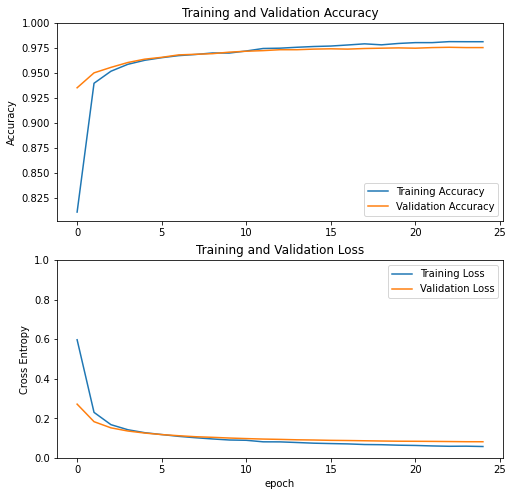

In [38]:
COMPILED_MODEL_PATH = log_file_path + model_name + '_compiledmodelsummary.txt'

# COMPILE MODEL
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #CategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])

# TRAIN THE MODEL
initial_epochs = epochs
# loss0, accuracy0 = model.evaluate(validation_dataset)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

# set Early Stopping to 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_epochs)
# use Checkpoints
checkpoint_path = models_path + MODEL_NAME +"/weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True,
                                                save_weights_only=False,
                                                save_freq=1233, #number of batches 1233
                                                mode='min')
# FIT THE MODEL
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[callback, checkpoint],
                    verbose=1)
# model = keras.models.load_model(models_path + MODEL_NAME)
# print(model)
# history = np.load(log_file_path + 'MODEL2_BASELINE_history.npy', allow_pickle='TRUE').item()

epochs_performed = len(history.history['loss'])
#epochs_performed = len(history['loss'])
print("epochs_performed: ", epochs_performed)
#save history
#np.save(log_file_path + 'MODEL2_BASELINE_history.npy', history.history)
# later - load history
# history=np.load('my_history.npy',allow_pickle='TRUE').item()
# save history - second option
#with open(log_file_path + 'MODEL2_BASELINE_history_json.json', 'w') as f:
#    json.dump(history.history, f)

# loss1, accuracy1 = model.evaluate(validation_dataset)
# print("loss after training: {:.2f}".format(loss1))
# print("accuracy after training: {:.2f}".format(accuracy1))

#PLOT TRAINING RESULTS
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# acc = history['accuracy']
# val_acc = history['val_accuracy']

# loss = history['loss']
# val_loss = history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
#plt.savefig(plots_path + model_name + '_acc_loss.png')
plt.show()

In [21]:
history

{'accuracy': [0.7664816379547119,
  0.9319443106651306,
  0.9479126930236816,
  0.9558969140052795,
  0.9608394503593445,
  0.9621321558952332,
  0.96524977684021,
  0.9672268033027649,
  0.9700403213500977,
  0.9695080518722534,
  0.9717131853103638,
  0.972929835319519,
  0.9735381603240967,
  0.9746787548065186,
  0.9760474562644958,
  0.9770359396934509,
  0.9771880507469177,
  0.9802296161651611,
  0.9788609147071838,
  0.98053377866745,
  0.9809139966964722,
  0.9816743731498718,
  0.98053377866745,
  0.9815223217010498,
  0.9816743731498718],
 'loss': [0.6931543350219727,
  0.2464263141155243,
  0.1808597445487976,
  0.15099330246448517,
  0.1322387456893921,
  0.12100748717784882,
  0.11171981692314148,
  0.10453994572162628,
  0.09768984466791153,
  0.09486732631921768,
  0.09023158252239227,
  0.08617106825113297,
  0.081162229180336,
  0.0787261426448822,
  0.07617249339818954,
  0.07355279475450516,
  0.07103192806243896,
  0.06694578379392624,
  0.06760934740304947,
  0.06

In [ ]:
#MODEL_NAME = 'MODEL2_BASELINE2'
#model.save(models_path + MODEL_NAME)

INFO:tensorflow:Assets written to: /content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/models/MODEL2_BASELINE2/assets


## Fine tuning

In [39]:
MODEL_NAME='MODEL2_IMPROVED'

In [40]:
base_model.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards (from 100 to 154)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [42]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', f1score_m, precision_m, recall_m]) #, metrics.AUC()

In [44]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [45]:
len(model.trainable_variables) #should be 56 (54 from MobileNetv2 + 2 from own layers)

56

In [56]:
initial_epochs = 25 #epochs parameter
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs
# set Early Stopping to 3 epochs
early_stopping_epochs = 3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_epochs)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset, 
                         callbacks=[callback],
                         verbose=1)

Epoch 25/50
411/411 [==============================] - 47s 113ms/step - loss: 0.0092 - accuracy: 0.9973 - f1score_m: 0.8919 - precision_m: 0.7984 - recall_m: 1.0152 - val_loss: 0.0650 - val_accuracy: 0.9836 - val_f1score_m: 0.8697 - val_precision_m: 0.7821 - val_recall_m: 0.9866
Epoch 26/50
411/411 [==============================] - 47s 113ms/step - loss: 0.0066 - accuracy: 0.9978 - f1score_m: 0.8911 - precision_m: 0.7998 - recall_m: 1.0112 - val_loss: 0.0641 - val_accuracy: 0.9866 - val_f1score_m: 0.8856 - val_precision_m: 0.7982 - val_recall_m: 1.0003
Epoch 27/50
411/411 [==============================] - 43s 102ms/step - loss: 0.0056 - accuracy: 0.9983 - f1score_m: 0.8899 - precision_m: 0.7993 - recall_m: 1.0088 - val_loss: 0.0637 - val_accuracy: 0.9863 - val_f1score_m: 0.8775 - val_precision_m: 0.7902 - val_recall_m: 0.9928
Epoch 28/50
411/411 [==============================] - 42s 101ms/step - loss: 0.0032 - accuracy: 0.9991 - f1score_m: 0.8837 - precision_m: 0.7941 - recall_m: 1.

In [57]:
model.save(models_path + MODEL_NAME)

INFO:tensorflow:Assets written to: /content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/models/MODEL2_IMPROVED/assets


In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

np.save(log_file_path + 'MODEL2_IMPROVED_history.npy', history_fine.history)
# save history - second option
# save history - second option
with open(log_file_path + 'MODEL2_IMPROVED_history_json.json', 'w') as f:
    json.dump(history_fine.history, f)

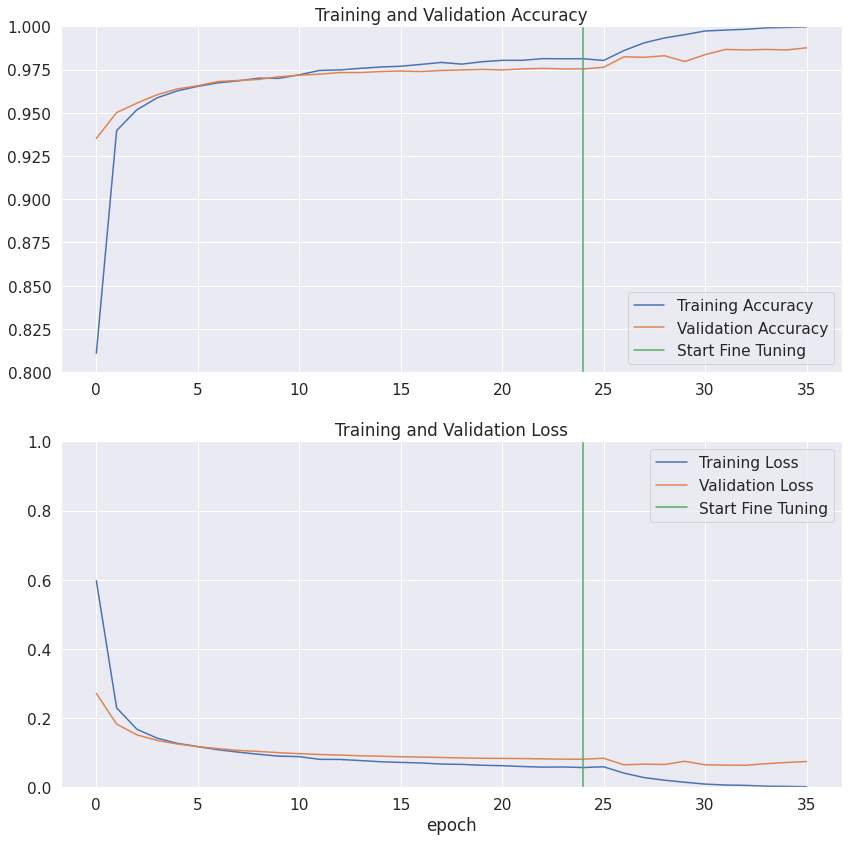

In [59]:
plt.figure(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
losstest1, accuracytest1, f1score_m1, precision_m1, recall_m1  = model.evaluate(validation_dataset)
print("TEST ON VALIDATON SET")
print(f'Test accuracy (validation_dataset): {accuracytest1}; Test loss (validation_dataset): {losstest1}')
print(f'Test f1score (validation_dataset): {f1score_m1}; Test precision (validation_dataset): {precision_m1}; Test recall (validation_dataset): {recall_m1}')

103/103 [==============================] - 11s 94ms/step - loss: 0.0744 - accuracy: 0.9875 - f1score_m: 0.8721 - precision_m: 0.7867 - recall_m: 0.9861
TEST ON VALIDATON SET
Test accuracy (validation_dataset): 0.9875228404998779; Test loss (validation_dataset): 0.07440371066331863
Test f1score (validation_dataset): 0.8720778226852417; Test precision (validation_dataset): 0.7867465615272522; Test recall (validation_dataset): 0.9860807061195374


# MODEL2 EVALUATING

Found 131 files belonging to 5 classes.
Found 800 files belonging to 5 classes.
images shape: (224, 224, 3)
images shape: (224, 224, 3)
Number of test_dataset1 batches: 5
Number of test_dataset2 batches: 25


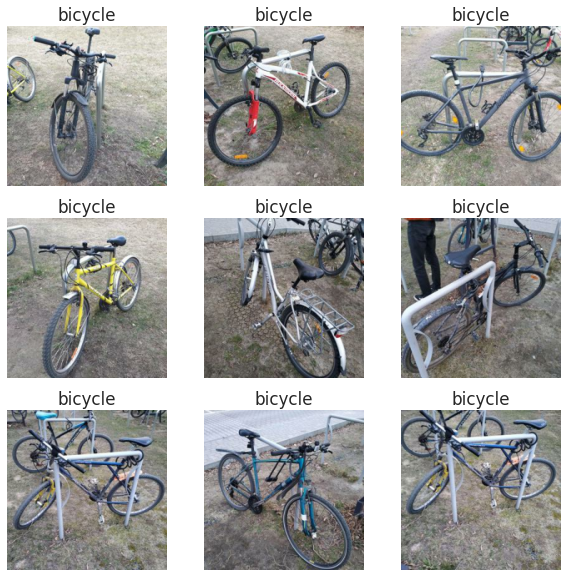

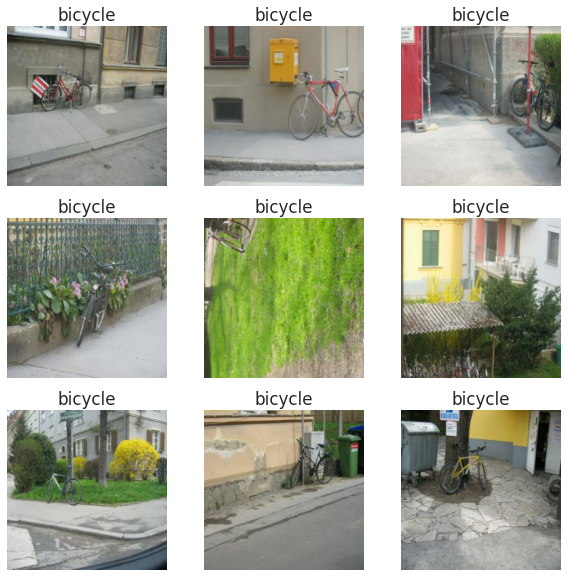

In [60]:
test_dataset1, test_dataset2, class_names1, class_names2 = prepare_testsets(testset_path1=testset1_path, testset_path2=testset2_path, 
                                                                            log_file_path=log_file_path, model_name='none', 
                                                                            plots_path=plots, batch_size=32, #batch_size=None or batch_size=1
                                                                            img_size_x=224, img_size_y=224)

In [61]:
losstest1, accuracytest1, f1score_m1, precision_m1, recall_m1  = model.evaluate(test_dataset1)
losstest2, accuracytest2, f1score_m2, precision_m2, recall_m2 = model.evaluate(test_dataset2)
print(MODEL_NAME)
print("TEST ON TEST SETS")
print(f'Test accuracy (testset1): {accuracytest1}; Test loss (testset1): {losstest1}')
print(f'Test f1score (testset1): {f1score_m1}; Test precision (testset1): {precision_m1}; Test recall (testset1): {recall_m1}')
print(f'Test accuracy (testset2): {accuracytest2}; Test loss (testset2): {losstest2}')
print(f'Test f1score (testset2): {f1score_m2}; Test precision (testset2): {precision_m2}; Test recall (testset2): {recall_m2}')

25/25 [==============================] - 2s 80ms/step - loss: 0.0863 - accuracy: 0.9762 - f1score_m: 0.7992 - precision_m: 0.8066 - recall_m: 0.7925
MODEL2_IMPROVED
TEST ON TEST SETS
Test accuracy (testset1): 0.7557252049446106; Test loss (testset1): 1.6623209714889526
Test f1score (testset1): 0.8464139103889465; Test precision (testset1): 0.8365529775619507; Test recall (testset1): 0.9303571581840515
Test accuracy (testset2): 0.9762499928474426; Test loss (testset2): 0.0863330140709877
Test f1score (testset2): 0.7992221713066101; Test precision (testset2): 0.8066354990005493; Test recall (testset2): 0.7925000190734863


In [62]:
test_dataset1_labels = get_labels_from_tfdataset(test_dataset1, batched=False)
test_dataset1_binarized_labels = label_binarize(test_dataset1_labels, classes=[0, 1, 2, 3, 4])
test_dataset1_predicted_probs = model.predict(test_dataset1)
test_dataset1_predicted_labels = np.argmax(test_dataset1_predicted_probs, axis=1)

In [63]:
test_dataset2_labels = get_labels_from_tfdataset(test_dataset2, batched=False)
test_dataset2_binarized_labels = label_binarize(test_dataset2_labels, classes=[0, 1, 2, 3, 4])
test_dataset2_predicted_probs = model.predict(test_dataset2)
test_dataset2_predicted_labels = np.argmax(test_dataset2_predicted_probs, axis=1)

### Test set 1 evaluation

Accuracy: 0.755725
Precision: 0.829447
Recall: 0.755725
F1 score: 0.705492
Cohens kappa: 0.690855
ROC AUC: 0.968055
Confusion matrix:  [[22  0  0  2  1]
 [ 0  1  5  0 17]
 [ 0  0 31  0  0]
 [ 0  0  0 31  0]
 [ 0  0  7  0 14]]


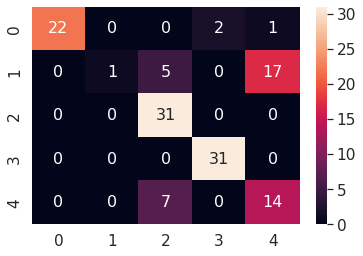

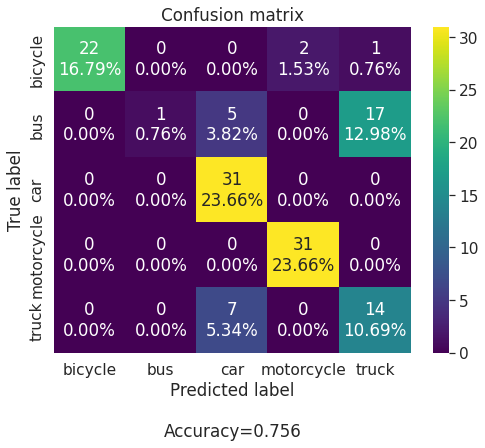

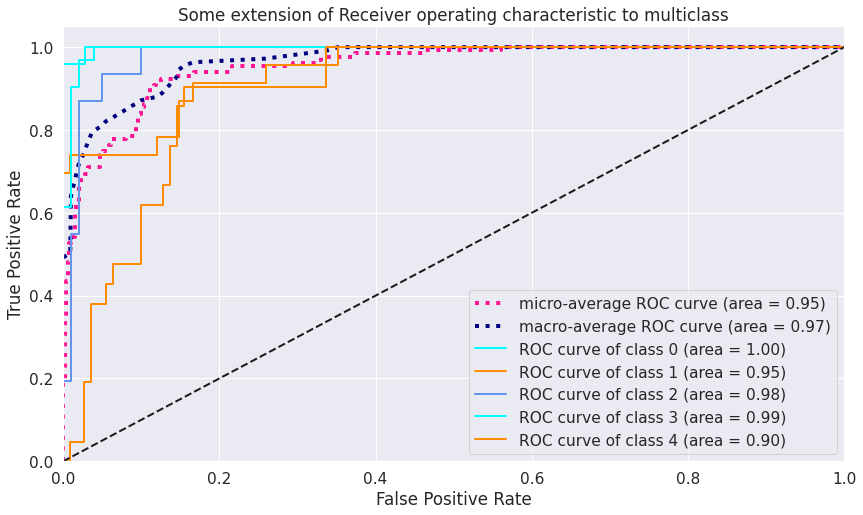

One-vs-One ROC AUC scores:
0.963582 (macro),
0.968055 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.963582 (macro),
0.968055 (weighted by prevalence)


In [64]:
test_dataset_labels = test_dataset1_labels
test_dataset_binarized_labels = test_dataset1_binarized_labels
test_dataset_predicted_probs = test_dataset1_predicted_probs
test_dataset_predicted_labels = test_dataset1_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

### Test set 2 evaluation

Accuracy: 0.976250
Precision: 0.977136
Recall: 0.976250
F1 score: 0.976119
Cohens kappa: 0.970313
ROC AUC: 0.998572
Confusion matrix:  [[158   0   0   2   0]
 [  0 160   0   0   0]
 [  0   0 158   0   2]
 [  0   0   0 160   0]
 [  0   2  13   0 145]]


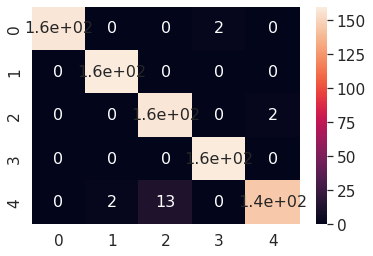

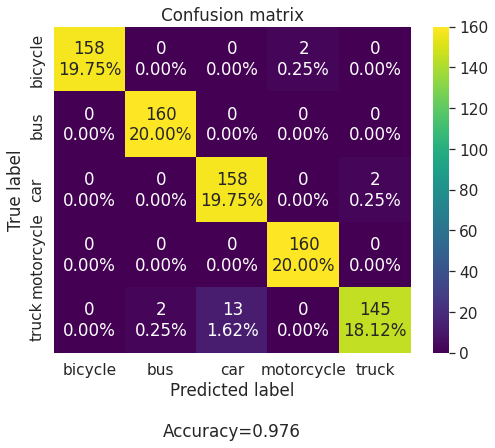

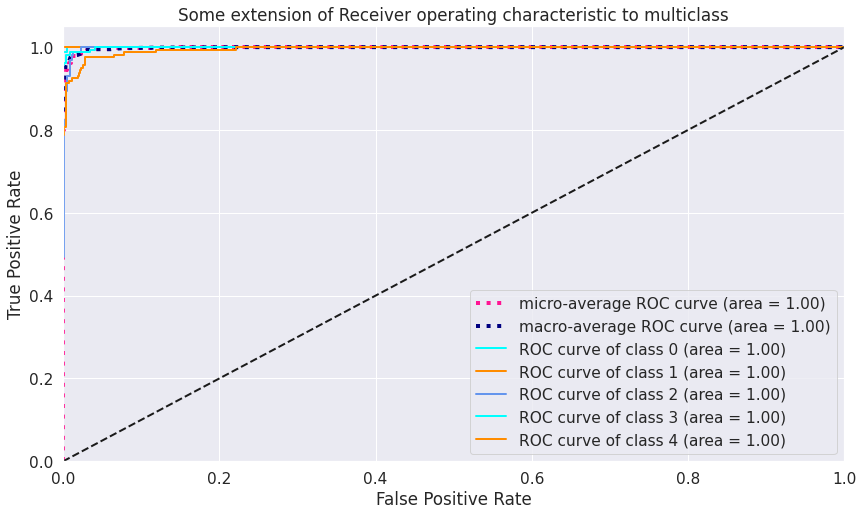

One-vs-One ROC AUC scores:
0.998572 (macro),
0.998572 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998572 (macro),
0.998572 (weighted by prevalence)


In [65]:
test_dataset_labels = test_dataset2_labels
test_dataset_binarized_labels = test_dataset2_binarized_labels
test_dataset_predicted_probs = test_dataset2_predicted_probs
test_dataset_predicted_labels = test_dataset2_predicted_labels
calculate_metrics(test_dataset_labels=test_dataset_labels, test_dataset_binarized_labels=test_dataset_binarized_labels, test_dataset_predicted_probs=test_dataset_predicted_probs, test_dataset_predicted_labels=test_dataset_predicted_labels)

# FINAL RESULTS

In [74]:
df = pd.read_csv(root_directory + 'results.csv', index_col=None)
df

model_name  train_examples  val_examples  epochs_performed  \
0  MODEL1_BASELINE            6474          1294                25   
1  MODEL2_BASELINE           13151          3286                25   
2  MODEL3_BASELINE           16437          3286                25   
3  MODEL2_IMPROVED           13151          3286                30   

   learning_rate optimizer  batch_size  val_loss  val_accuracy  test1_loss  \
0        0.00010      Adam          32  0.086922      0.972179    0.832436   
1        0.00010      Adam          32  0.081698      0.974437    0.912332   
2        0.00010      Adam          32  0.048375      0.985697    0.803597   
3        0.00001   RMSprop          32  0.074404      0.987523    1.662321   

   test1_accuracy  test2_loss  test2_accuracy  test1_f1_score  test1_ROC  \
0        0.770992    0.099143         0.96500        0.716510   0.966050   
1        0.763359    0.068278         0.97750        0.701382   0.957340   
2        0.770992    0.065667         0.97875        0.724929   0.967337   
3        0.755725    0.086333         0.97625        0.705492   0.968055   

   test2_f1_score  test2_ROC  
0        0.964818   0.995930  
1        0.977309   0.996211  
2        0.978626   0.996771  
3        0.976119   0.998572

In [75]:
df.T

0                1                2  \
model_name        MODEL1_BASELINE  MODEL2_BASELINE  MODEL3_BASELINE   
train_examples               6474            13151            16437   
val_examples                 1294             3286             3286   
epochs_performed               25               25               25   
learning_rate              0.0001           0.0001           0.0001   
optimizer                    Adam             Adam             Adam   
batch_size                     32               32               32   
val_loss                 0.086922         0.081698         0.048375   
val_accuracy             0.972179         0.974437         0.985697   
test1_loss               0.832436         0.912332         0.803597   
test1_accuracy           0.770992         0.763359         0.770992   
test2_loss               0.099143         0.068278         0.065667   
test2_accuracy              0.965           0.9775          0.97875   
test1_f1_score            0.71651         0.701382         0.724929   
test1_ROC                 0.96605          0.95734         0.967337   
test2_f1_score           0.964818         0.977309         0.978626   
test2_ROC                 0.99593         0.996211         0.996771   

                                3  
model_name        MODEL2_IMPROVED  
train_examples              13151  
val_examples                 3286  
epochs_performed               30  
learning_rate             0.00001  
optimizer                 RMSprop  
batch_size                     32  
val_loss                 0.074404  
val_accuracy             0.987523  
test1_loss               1.662321  
test1_accuracy           0.755725  
test2_loss               0.086333  
test2_accuracy            0.97625  
test1_f1_score           0.705492  
test1_ROC                0.968055  
test2_f1_score           0.976119  
test2_ROC                0.998572

In [78]:
df = pd.read_csv(root_directory + 'results.csv', index_col=0)
df

train_examples  val_examples  epochs_performed  \
model_name                                                        
MODEL1_BASELINE            6474          1294                25   
MODEL2_BASELINE           13151          3286                25   
MODEL3_BASELINE           16437          3286                25   
MODEL2_IMPROVED           13151          3286                30   

                 learning_rate optimizer  batch_size  val_loss  val_accuracy  \
model_name                                                                     
MODEL1_BASELINE        0.00010      Adam          32  0.086922      0.972179   
MODEL2_BASELINE        0.00010      Adam          32  0.081698      0.974437   
MODEL3_BASELINE        0.00010      Adam          32  0.048375      0.985697   
MODEL2_IMPROVED        0.00001   RMSprop          32  0.074404      0.987523   

                 test1_loss  test1_accuracy  test2_loss  test2_accuracy  \
model_name                                                                
MODEL1_BASELINE    0.832436        0.770992    0.099143         0.96500   
MODEL2_BASELINE    0.912332        0.763359    0.068278         0.97750   
MODEL3_BASELINE    0.803597        0.770992    0.065667         0.97875   
MODEL2_IMPROVED    1.662321        0.755725    0.086333         0.97625   

                 test1_f1_score  test1_ROC  test2_f1_score  test2_ROC  
model_name                                                             
MODEL1_BASELINE        0.716510   0.966050        0.964818   0.995930  
MODEL2_BASELINE        0.701382   0.957340        0.977309   0.996211  
MODEL3_BASELINE        0.724929   0.967337        0.978626   0.996771  
MODEL2_IMPROVED        0.705492   0.968055        0.976119   0.998572

In [80]:
df.transpose()

model_name       MODEL1_BASELINE MODEL2_BASELINE MODEL3_BASELINE  \
train_examples              6474           13151           16437   
val_examples                1294            3286            3286   
epochs_performed              25              25              25   
learning_rate             0.0001          0.0001          0.0001   
optimizer                   Adam            Adam            Adam   
batch_size                    32              32              32   
val_loss                0.086922        0.081698        0.048375   
val_accuracy            0.972179        0.974437        0.985697   
test1_loss              0.832436        0.912332        0.803597   
test1_accuracy          0.770992        0.763359        0.770992   
test2_loss              0.099143        0.068278        0.065667   
test2_accuracy             0.965          0.9775         0.97875   
test1_f1_score           0.71651        0.701382        0.724929   
test1_ROC                0.96605         0.95734        0.967337   
test2_f1_score          0.964818        0.977309        0.978626   
test2_ROC                0.99593        0.996211        0.996771   

model_name       MODEL2_IMPROVED  
train_examples             13151  
val_examples                3286  
epochs_performed              30  
learning_rate            0.00001  
optimizer                RMSprop  
batch_size                    32  
val_loss                0.074404  
val_accuracy            0.987523  
test1_loss              1.662321  
test1_accuracy          0.755725  
test2_loss              0.086333  
test2_accuracy           0.97625  
test1_f1_score          0.705492  
test1_ROC               0.968055  
test2_f1_score          0.976119  
test2_ROC               0.998572

# Useful sources:


*   https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing
*   https://analyticsindiamag.com/hands-on-guide-to-multi-class-classification-using-mobilenet_v2/?fbclid=IwAR1apE5HeR5YsWM-1uNlPzaW8fsMEVZuTINxzX17TdWSc5ojPqXpPzOpDlA
* https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
* https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
* https://neptune.ai/blog/keras-metrics
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/check-point-deep-learning-models-keras/



# OLD CODE

In [ ]:
test_dataset1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_dataset1.as_numpy_iterator().next()

(array([[[[ 76.35204 ,  78.36735 ,  73.505104],
          [ 65.438774,  67.60715 ,  63.09184 ],
          [ 71.81632 ,  74.86225 ,  71.581635],
          ...,
          [178.05104 , 201.52548 , 216.59688 ],
          [100.02996 , 120.47382 , 132.11665 ],
          [169.10884 , 187.25166 , 197.32307 ]],
 
         [[124.658165, 127.28572 , 124.64286 ],
          [108.83673 , 113.45407 , 110.09693 ],
          [ 72.84694 ,  75.9898  ,  74.05613 ],
          ...,
          [188.35208 , 212.5     , 227.5714  ],
          [113.39733 , 133.8718  , 146.01974 ],
          [114.53102 , 133.0565  , 143.3728  ]],
 
         [[134.06633 , 139.58673 , 139.61224 ],
          [118.64796 , 125.08673 , 124.65306 ],
          [106.38776 , 112.27551 , 112.57653 ],
          ...,
          [189.31143 , 214.42874 , 229.72974 ],
          [144.60672 , 165.53526 , 179.33118 ],
          [ 83.67769 , 103.68279 , 114.87152 ]],
 
         ...,
 
         [[ 89.617325,  78.617325,  74.617325],
          [ 89.352

In [ ]:
np.array(class_names1)

array(['bicycle', 'bus', 'car', 'motorcycle', 'truck'], dtype='<U10')

TypeError: ignored

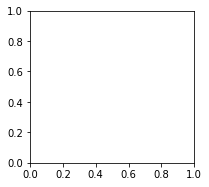

In [ ]:
# get and decode the predictions
classes = np.array(class_names1)
predicted_batch = model.predict(test_dataset1)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label = classes[predicted_id]
plt.figure(figsize=(10,7))
plt.subplots_adjust(hspace=0.5)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_dataset1[i])
  plt.title(predicted_label[i].title())
  plt.axis('off')
  plt.tight_layout
  plt.suptitle('Model predictions')

In [ ]:
nr_test1_batches = tf.data.experimental.cardinality(test_dataset1)
print("number of test batches: ", int(nr_test1_batches))

images, labels = tuple(zip(*test_dataset1))
images = np.array(images)
labels = np.array(labels)

for i in range(nr_test1_batches.numpy()):
  if i == 0:
    labels_array = labels[i].numpy()
    images_array = images[i].numpy()
  else:
    labels_array = np.concatenate((labels_array, labels[i].numpy()), axis=0)
    images_array = np.concatenate((images_array, images[i].numpy()), axis=0)

display(labels_array)
print("len(labels_array): ", len(labels_array))
display(images_array)
print("images_array.shape: ", images_array.shape)
print("len(images_array): ", len(images_array))

number of test batches:  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


array([3, 4, 3, 0, 3, 2, 2, 3, 1, 3, 3, 2, 1, 3, 2, 1, 4, 2, 0, 1, 1, 1,
       0, 0, 3, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 1, 0, 1,
       2, 2, 4, 3, 2, 4, 3, 2, 4, 1, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 4, 3,
       1, 2, 1, 0, 2, 0, 2, 2, 4, 3, 3, 1, 3, 0, 3, 1, 1, 4, 3, 3, 2, 2,
       1, 3, 1, 1, 0, 2, 4, 1, 3, 3, 2, 2, 1, 4, 2, 1, 3, 3, 3, 0, 4, 0,
       1, 4, 4, 4, 3, 4, 0, 1, 3, 4, 0, 0, 4, 3, 2, 3, 3, 4, 1, 4, 0],
      dtype=int32)

len(labels_array):  131


array([[[[1.57719376e+02, 1.56719376e+02, 1.52719376e+02],
         [1.61229584e+02, 1.60229584e+02, 1.56229584e+02],
         [1.63693878e+02, 1.62693878e+02, 1.58693878e+02],
         ...,
         [2.22025513e+02, 2.26454102e+02, 2.32785721e+02],
         [2.20540802e+02, 2.27142853e+02, 2.34714294e+02],
         [2.21071442e+02, 2.28071442e+02, 2.36071442e+02]],

        [[1.51086746e+02, 1.50086746e+02, 1.46086746e+02],
         [1.55948990e+02, 1.54948990e+02, 1.50948990e+02],
         [1.60219376e+02, 1.59219376e+02, 1.55219376e+02],
         ...,
         [2.22785706e+02, 2.29071442e+02, 2.35071442e+02],
         [2.22428574e+02, 2.29428574e+02, 2.37000015e+02],
         [2.23158173e+02, 2.30556137e+02, 2.38357162e+02]],

        [[1.49974487e+02, 1.48974487e+02, 1.44974487e+02],
         [1.55494904e+02, 1.54494904e+02, 1.50494904e+02],
         [1.61000000e+02, 1.60000000e+02, 1.56000000e+02],
         ...,
         [2.23872437e+02, 2.30872467e+02, 2.36642868e+02],
         [

images_array.shape:  (131, 224, 224, 3)
len(images_array):  131


In [ ]:
images.shape

(5,)

In [ ]:
image_batch.shape

(32, 224, 224, 3)

In [ ]:
images

array([<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
       array([[[[201.07143 , 228.07143 , 245.07143 ],
                [201.07143 , 228.07143 , 245.07143 ],
                [201.07143 , 228.07143 , 245.07143 ],
                ...,
                [204.07143 , 233.07143 , 251.07143 ],
                [204.07143 , 233.07143 , 251.07143 ],
                [204.07143 , 233.07143 , 251.07143 ]],

               [[202.      , 229.      , 246.      ],
                [202.04591 , 229.      , 245.90816 ],
                [202.21428 , 229.      , 245.57143 ],
                ...,
                [205.21428 , 233.78572 , 251.57143 ],
                [205.21428 , 233.78572 , 251.57143 ],
                [205.21428 , 233.78572 , 251.57143 ]],

               [[202.35715 , 229.35715 , 246.35715 ],
                [202.57143 , 229.35715 , 245.92857 ],
                [203.35715 , 229.35715 , 244.35715 ],
                ...,
                [206.35715 , 233.35715 , 250.35715 ],
   

array([[-4.662303  , -4.8946185 , -0.6193537 ,  1.2581486 , -4.8187027 ],
       [ 6.035137  , -5.0809507 , -3.850081  ,  0.3358262 , -6.2734246 ],
       [-5.9440084 , -3.7759984 ,  3.4240746 , -5.4176173 , -3.5732436 ],
       [-6.929381  , -4.987739  ,  3.6291482 , -4.468205  , -3.3253644 ],
       [ 1.768094  , -5.9870033 , -3.113018  , -2.6688874 , -3.89831   ],
       [ 5.3162746 , -3.8215678 , -2.55028   , -1.391141  , -4.66854   ],
       [ 1.2766312 , -5.9767933 , -3.4302762 , -2.3244832 , -7.0003195 ],
       [-2.715868  , -5.8786187 , -3.1791997 ,  0.6565185 , -5.2023864 ],
       [ 3.3810773 , -5.4127207 , -3.6946068 ,  1.7537885 , -5.3273964 ],
       [-2.3377762 , -5.9556003 , -3.9681787 ,  2.9191966 , -4.084296  ],
       [-2.8063173 , -5.711618  , -3.1504056 ,  1.6246551 , -5.4614687 ],
       [-5.106798  , -2.6526415 ,  3.6647923 , -4.776694  , -2.885179  ],
       [-6.473292  , -2.50283   , -0.9629203 , -5.4850025 ,  1.8227532 ],
       [-2.5796688 , -5.9744916 , -3.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predictions:
 [3 0 2 2 0 0 0 3 0 3 3 2 4 3 4 3 3 3 0 0 3 3 0 2 2 3 3 2 0 3 2 4 4 2 0 4 2
 3 2 2 2 4 4 0 4 4 2 4 2 2 3 3 2 2 4 0 2 2 3 2 2 2 3 4 3 2 2 2 2 2 0 2 2 2
 2 2 2 3 3 4 0 4 2 0 2 4 4 2 0 4 3 0 2 0 0 3 4 2 0 2 3 0 2 2 2 3 4 4 4 2 3
 0 0 2 4 4 3 4 2 4 3 2 0 2 3 2 0 3 3 1 4]
len predictions:  131
Labels:
 [3 4 3 0 3 2 2 3 1 3 3 2 1 3 2 1 4 2 0 1 1 1 0 0 3 2 4 0 0 0 2 0 0 0 0 4 0
 2 2 0 0 1 0 1 2 2 4 3 2 4 3 2 4 1 2 2 2 2 2 3 2 2 3 3 4 3 1 2 1 0 2 0 2 2
 4 3 3 1 3 0 3 1 1 4 3 3 2 2 1 3 1 1 0 2 4 1 3 3 2 2 1 4 2 1 3 3 3 0 4 0 1
 4 4 4 3 4 0 1 3 4 0 0 4 3 2 3 3 4 1 4 0]
len labels:  131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


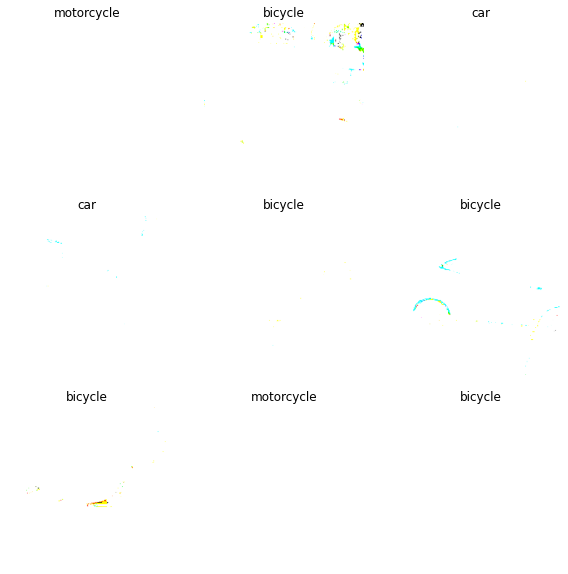

In [ ]:
# Retrieve a batch of images from the test set
#image_batch, label_batch = test_dataset1.as_numpy_iterator().next()
#predictions = model.predict_on_batch(image_batch).flatten()
predictions = model.predict(test_dataset1)
display(predictions)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.nn.softmax(predictions)
#predictions = np.argmax(predictions)
predictions = np.argmax(predictions, axis=1)
#x = np.array([0.33, 0.33, 0.33])
#np.argmax(x)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions) #predictions.numpy()
print("len predictions: ", len(predictions))
print('Labels:\n', labels_array)
print("len labels: ", len(labels_array))

class_names = class_names1
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images_array[i]) #.astype("uint8")
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
iter = test_dataset1.make_one_shot_iterator()
el = iter.get_next()

AttributeError: ignored

In [ ]:
iter_train_infer = tf.data.make_initializable_iterator(test_dataset1)

AttributeError: ignored

In [ ]:
iter = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(test_dataset1),
                                           tf.compat.v1.data.get_output_shapes(test_dataset1))

In [ ]:
iter

In [ ]:
# create the initialisation operations
train_init_op = iter.make_initializer(test_dataset1)

features, labels = iter.get_next()

print([features, labels])

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
[<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[254.2551  , 254.2551  , 254.53061 ],
         [249.84183 , 250.05612 , 252.02551 ],
         [252.80612 , 253.80612 , 255.      ],
         ...,
         [166.21951 , 163.21951 , 158.21951 ],
         [236.8781  , 235.44954 , 232.02098 ],
         [254.5357  , 253.33672 , 250.33672 ]],

        [[250.9847  , 250.9847  , 252.7551  ],
         [252.93367 , 253.14795 , 254.38264 ],
         [253.92346 , 254.92346 , 255.      ],
         ...,
         [193.1029  , 190.1029  , 185.1029  ],
         [247.76042 , 245.99513 , 242.56657 ],
         [249.89276 , 246.67334 , 243.67334 ]],

        [[252.7449  , 252.7449  , 254.0051  ],
         [254.32654 , 254.54082 , 254.69388 ],
         [

In [ ]:
image_batch, label_batch = test_dataset1.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [ ]:
image_batch, label_batch = test_dataset1.as_numpy_iterator().next()
predictions = model.predict(image_batch).flatten()

In [ ]:
image_batch

array([[[[245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         ...,
         [ 89.301125,  93.301125, 103.58686 ],
         [ 76.64783 ,  82.21927 ,  94.00499 ],
         [ 83.49511 ,  89.49511 , 103.35229 ]],

        [[245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         ...,
         [ 81.086914,  85.086914,  95.37265 ],
         [ 78.678505,  84.24995 ,  96.03567 ],
         [ 87.30633 ,  93.30633 , 107.163506]],

        [[245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         [245.      , 243.      , 246.      ],
         ...,
         [ 74.35235 ,  78.35235 ,  88.638084],
         [ 79.938736,  85.51018 ,  97.2959  ],
         [ 82.89294 ,  88.89294 , 102.750114]],

        ...,

        [[116.071396, 113.071396, 106.071396],
         [116.071396, 113.071396, 106.071396]

In [ ]:
nr_test1_batches = tf.data.experimental.cardinality(test_dataset1)
print(int(nr_test1_batches))

5


In [ ]:
type(nr_test1_batches.numpy())

numpy.int64

In [ ]:
print('Number of test_dataset1 batches: %d' % nr_test1_batches)

Number of test_dataset1 batches: 5


In [ ]:
label_batch

array([4, 3, 2, 0, 4, 4, 4, 3, 3, 3, 4, 3, 0, 4, 3, 2, 1, 1, 0, 3, 3, 1,
       3, 1, 0, 3, 2, 3, 1, 4, 1, 0], dtype=int32)

In [ ]:
len(label_batch)

32

In [ ]:
classes = np.argmax(predictions)
classes

60

In [ ]:
predictions

array([-5.723563  , -2.432262  ,  0.774928  , -5.8900805 ,  1.2030663 ,
       -1.5911194 , -5.237181  , -3.2272403 ,  3.4318151 , -4.9124517 ,
       -6.929381  , -4.987739  ,  3.6291482 , -4.468205  , -3.3253644 ,
        3.5464375 , -6.4722114 , -4.8000503 , -0.1835701 , -5.3611765 ,
       -6.0227118 , -2.3904197 , -1.3089362 , -4.9333744 ,  2.2165575 ,
       -5.716719  , -3.14088   ,  0.87991947, -6.990963  ,  2.3768694 ,
       -5.095209  , -2.4688456 , -1.1236693 , -4.5048847 ,  3.620781  ,
       -3.844883  , -7.782205  , -3.899965  ,  2.5149581 , -5.8557415 ,
       -2.5796688 , -5.9744916 , -3.1480403 ,  2.8927588 , -4.020308  ,
       -3.6140761 , -6.017673  , -1.3912996 ,  2.4895942 , -5.4922757 ,
       -7.447345  , -2.6067626 ,  3.161419  , -5.486965  , -1.4002284 ,
       -2.3377762 , -5.9556003 , -3.9681787 ,  2.9191966 , -4.084296  ,
        5.3162746 , -3.8215678 , -2.55028   , -1.391141  , -4.66854   ,
       -6.91542   , -2.420389  , -0.7817767 , -5.007926  ,  1.64

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(test_dataset1, verbose=0)
# predict crisp classes for test set
# AttributeError: 'Functional' object has no attribute 'predict_classes'. 
# The predict_classes method is only available for the Sequential class (which is the class of your first model) but not for the Model class (the class of your second model).
# With the Model class, you can use the predict method which will give you a vector of probabilities and then get the argmax of this vector (with np.argmax(y_pred1,axis=1)).
# yhat_classes = model.predict_classes(test_dataset1, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1) #axis=1

In [ ]:
yhat_classes

array([4, 4, 4, 4, 2, 0, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 3, 3, 3, 0, 2, 2,
       4, 0, 2, 4, 3, 4, 0, 2, 0, 4, 2, 2, 3, 1, 3, 0, 2, 2, 3, 2, 0, 2,
       0, 2, 2, 3, 0, 3, 3, 4, 3, 2, 2, 3, 3, 2, 0, 2, 2, 4, 2, 3, 3, 4,
       0, 2, 3, 3, 3, 2, 4, 4, 2, 4, 0, 0, 4, 0, 3, 2, 0, 2, 0, 4, 2, 0,
       2, 2, 3, 4, 4, 0, 0, 0, 3, 0, 3, 2, 3, 4, 3, 2, 4, 4, 2, 0, 3, 2,
       2, 0, 2, 3, 2, 3, 4, 2, 0, 3, 2, 0, 2, 2, 3, 2, 3, 2, 2, 3, 2])

In [ ]:
len(yhat_classes)

131

In [ ]:
yhat_probs

array([[-5.2006783 , -2.141906  ,  2.8672748 , -4.0245056 , -3.6904564 ],
       [-5.92758   , -1.4436643 , -1.3658254 , -6.541601  ,  0.7628894 ],
       [ 3.2683456 , -5.6040063 , -2.3539987 , -3.5839732 , -5.5946555 ],
       [-1.8289378 , -4.2914357 , -3.224053  ,  2.0932505 , -5.5839586 ],
       [-4.9044704 , -6.1150575 ,  2.428482  , -3.9387693 , -5.1350064 ],
       [-2.2231338 , -4.042293  , -4.93548   , -3.6547713 , -2.5284786 ],
       [-2.3377762 , -5.9556003 , -3.9681787 ,  2.9191966 , -4.084296  ],
       [-5.027067  , -1.4529058 , -3.7944174 , -6.493698  ,  3.3110158 ],
       [-5.1979923 , -5.491206  , -1.7898871 ,  2.2538242 , -4.751356  ],
       [ 5.9005013 , -4.4253206 , -3.0238295 , -1.3518044 , -4.6868696 ],
       [-4.0028424 , -1.0348583 , -2.7347527 , -4.685849  ,  3.0952268 ],
       [-5.223381  , -0.54902554, -2.7031531 , -4.7895374 ,  3.1441765 ],
       [-4.297599  ,  0.57297784, -3.1505451 , -6.430512  , -0.8000827 ],
       [-6.599805  , -4.788226  ,  3.7

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

In [ ]:
yhat_probs

array([-5.2006783 , -5.92758   ,  3.2683456 , -1.8289378 , -4.9044704 ,
       -2.2231338 , -2.3377762 , -5.027067  , -5.1979923 ,  5.9005013 ,
       -4.0028424 , -5.223381  , -4.297599  , -6.599805  , -6.4427624 ,
       -3.780219  , -6.1870747 , -5.716719  ,  3.3227968 , -5.120218  ,
       -6.293912  , -2.5796688 , -5.294464  , -4.407085  ,  5.610229  ,
       -4.662303  , -4.0772305 , -0.41792127,  0.27941597, -5.2512426 ,
       -2.987177  , -5.723563  , -5.914834  , -6.165382  , -4.7459006 ,
        1.2766312 ,  5.8426847 , -2.8063173 ,  2.1224074 , -6.91542   ,
       -5.0957966 , -5.095209  , -5.9440084 , -4.3197637 , -4.5316267 ,
       -5.578906  , -3.217359  , -1.7906418 ,  4.44098   , -7.548586  ,
       -7.3927283 , -5.903655  ,  4.0169983 , -3.2061539 , -3.0794003 ,
       -6.445779  , -6.473292  , -3.4847999 ,  5.3162746 , -6.847884  ,
       -5.8678093 , -3.157425  , -5.682288  , -4.8194876 , -3.2734354 ,
       -6.5218887 , -6.0227118 , -7.447345  , -5.5206127 , -3.17

In [ ]:
len(yhat_probs)

131

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
test_dataset1.as_numpy_iterator().next()

(array([[[[ 89.005104, 105.07653 , 117.85204 ],
          [ 89.27041 , 105.341835, 118.015305],
          [ 90.35714 , 106.428566, 119.16326 ],
          ...,
          [151.19386 , 146.19386 , 143.19386 ],
          [149.94386 , 144.94386 , 141.94386 ],
          [149.64796 , 144.64796 , 141.64796 ]],
 
         [[ 89.484695, 106.05612 , 114.841835],
          [ 90.21429 , 106.78571 , 114.14286 ],
          [ 90.494896, 107.06632 , 115.28062 ],
          ...,
          [148.85712 , 143.85712 , 140.85712 ],
          [146.0459  , 141.0459  , 138.0459  ],
          [144.64284 , 139.64284 , 136.64284 ]],
 
         [[ 90.61735 , 105.311226, 108.40816 ],
          [ 90.28571 , 105.48979 , 107.41327 ],
          [ 90.158165, 105.05612 , 107.68367 ],
          ...,
          [148.301   , 143.301   , 140.301   ],
          [145.2806  , 140.2806  , 137.2806  ],
          [144.11734 , 139.11734 , 136.11734 ]],
 
         ...,
 
         [[113.142876, 112.142876, 118.142876],
          [111.362

In [ ]:
for images, labels in test_dataset1.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
numpy_labels

array([3, 0, 4, 4, 0, 4, 4, 2, 3, 0, 4, 1, 2, 3, 2, 2, 1, 2, 0, 0, 0, 2,
       0, 3, 4, 1, 0, 2, 3, 2, 0, 1], dtype=int32)

In [ ]:
images, labels = tuple(zip(*test_dataset1))

In [ ]:
images, labels = tuple(zip(*test_dataset1))
images = np.array(images)
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
np.empty()

TypeError: ignored

In [ ]:
for i in range(nr_test1_batches.numpy()):
  if i == 0:
    labels_array = labels[i].numpy()
    display(labels_array)
  else:
    labels_array = np.concatenate((labels_array, labels[i].numpy()), axis=0)
  #display(labels[i])
  #display(labels[i].numpy())

array([1, 4, 2, 0, 2, 1, 0, 3, 4, 2, 2, 1, 3, 4, 1, 1, 2, 4, 3, 1, 2, 4,
       4, 0, 3, 3, 2, 4, 2, 4, 4, 1], dtype=int32)

In [ ]:
labels_array

array([1, 4, 2, 0, 2, 1, 0, 3, 4, 2, 2, 1, 3, 4, 1, 1, 2, 4, 3, 1, 2, 4,
       4, 0, 3, 3, 2, 4, 2, 4, 4, 1, 2, 0, 0, 3, 1, 1, 2, 0, 2, 3, 3, 2,
       0, 3, 0, 2, 1, 2, 0, 0, 3, 1, 3, 4, 0, 0, 3, 3, 0, 0, 1, 1, 2, 0,
       4, 0, 0, 2, 0, 4, 0, 2, 4, 3, 0, 2, 4, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       4, 0, 2, 3, 3, 1, 2, 4, 4, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 2, 3, 1,
       2, 4, 1, 4, 3, 3, 3, 3, 0, 2, 1, 2, 3, 0, 3, 4, 1, 4, 3, 1, 1],
      dtype=int32)

In [ ]:
np.argmax(labels_array, axis=0)

1

In [ ]:
len(labels_array)

131

In [ ]:
labels[0]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 4, 2, 0, 2, 1, 0, 3, 4, 2, 2, 1, 3, 4, 1, 1, 2, 4, 3, 1, 2, 4,
       4, 0, 3, 3, 2, 4, 2, 4, 4, 1], dtype=int32)>

In [ ]:
labels.eval()

AttributeError: ignored

In [ ]:
labels.numpy()

AttributeError: ignored

In [ ]:
type(labels)

numpy.ndarray

In [ ]:
for x in np.nditer(labels, flags=["refs_OK"], op_flags=["readwrite"]):
    print(x, end=' ')

ValueError: ignored

In [ ]:
yhat_classes

array([2, 4, 0, 3, 2, 0, 3, 4, 3, 0, 4, 4, 1, 2, 2, 3, 4, 4, 0, 2, 2, 3,
       2, 2, 0, 3, 4, 3, 0, 2, 2, 4, 4, 2, 3, 0, 0, 3, 0, 4, 2, 4, 2, 4,
       2, 2, 4, 3, 0, 2, 4, 2, 0, 3, 2, 2, 4, 2, 0, 2, 2, 3, 2, 4, 3, 4,
       4, 2, 2, 3, 4, 2, 2, 3, 0, 4, 3, 2, 2, 3, 4, 2, 2, 0, 2, 4, 0, 2,
       2, 2, 0, 3, 2, 3, 3, 0, 0, 2, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 4, 4,
       0, 3, 2, 2, 0, 3, 0, 3, 2, 2, 3, 4, 0, 3, 0, 2, 3, 2, 0, 0, 4])

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels_array, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(labels_array, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(labels_array, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels_array, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.152672
Precision: 0.121232
Recall: 0.152672
F1 score: 0.133809


In [ ]:
np.argmax(yhat_probs, axis=0)

array([121,  35, 117,  69,   0])

In [ ]:
np.argmax(yhat_probs)

605

In [ ]:
# kappa
kappa = cohen_kappa_score(labels_array, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#auc = roc_auc_score(labels_array, np.argmax(yhat_probs, axis=0), average='weighted', multi_class='ovr')
#print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(labels_array, yhat_classes)
print(matrix)

Cohens kappa: -0.027223
[[ 4  0 10  6  5]
 [ 6  0  8  4  5]
 [ 8  0 10 10  3]
 [ 3  1 11  7  9]
 [ 4  0  9  4  4]]


In [ ]:
labels_array.ravel()

array([1, 4, 2, 0, 2, 1, 0, 3, 4, 2, 2, 1, 3, 4, 1, 1, 2, 4, 3, 1, 2, 4,
       4, 0, 3, 3, 2, 4, 2, 4, 4, 1, 2, 0, 0, 3, 1, 1, 2, 0, 2, 3, 3, 2,
       0, 3, 0, 2, 1, 2, 0, 0, 3, 1, 3, 4, 0, 0, 3, 3, 0, 0, 1, 1, 2, 0,
       4, 0, 0, 2, 0, 4, 0, 2, 4, 3, 0, 2, 4, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       4, 0, 2, 3, 3, 1, 2, 4, 4, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 2, 3, 1,
       2, 4, 1, 4, 3, 3, 3, 3, 0, 2, 1, 2, 3, 0, 3, 4, 1, 4, 3, 1, 1],
      dtype=int32)

In [ ]:
yhat_classes.ravel()

array([4, 4, 4, 4, 2, 0, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 3, 3, 3, 0, 2, 2,
       4, 0, 2, 4, 3, 4, 0, 2, 0, 4, 2, 2, 3, 1, 3, 0, 2, 2, 3, 2, 0, 2,
       0, 2, 2, 3, 0, 3, 3, 4, 3, 2, 2, 3, 3, 2, 0, 2, 2, 4, 2, 3, 3, 4,
       0, 2, 3, 3, 3, 2, 4, 4, 2, 4, 0, 0, 4, 0, 3, 2, 0, 2, 0, 4, 2, 0,
       2, 2, 3, 4, 4, 0, 0, 0, 3, 0, 3, 2, 3, 4, 3, 2, 4, 4, 2, 0, 3, 2,
       2, 0, 2, 3, 2, 3, 4, 2, 0, 3, 2, 0, 2, 2, 3, 2, 3, 2, 2, 3, 2])

In [ ]:
macro_roc_auc_ovo = roc_auc_score(labels_array.ravel(), yhat_classes.ravel(), multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

AxisError: ignored